# Classification Model Project

Please fill out:
* Student name: Max Steele
* Student pace: full time
* Scheduled project review date/time: Friday, October 9 at 4 PM
* Instructor name: James Irving
* Blog post URL: <a href="https://zero731.github.io/feature_engineering"> blog post </a>

## Table of Contents

<font size=3rem>
    
- **[Introduction](#Introduction)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[INTERPRET](#INTERPRET)**<br>
- **[Conclusions/Recommendations](#Conclusions/Recommendations)<br>**
</font>

# Introduction

My goal for this project was to build a classifier to predict the seasonal flu vaccination status (did not receive flu vaccine vs. did receive the vaccine). The main purpose of the model was to make these predictions as accurately as possible, while maximizing the recall for individuals who elect not to get the vaccine. By building an accurate model and focusing on those that don't get vaccinated, I can provide insights into which factors are most important in determining vaccination status and which subgroups of the population pro-vaccination efforts/ organizations should focus on most to maximize the benefits of herd immunity.

Data files were obtained from <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/"> DrivenData</a> (<a href="https://www.cdc.gov/nchs/nis/data_files_h1n1.htm">Source</a>: CDC, NCRID and NCHS (2012), National 2009 H1N1 Flu Survey). They contain the results of a phone survey conducted in 2009 which collected some basic demogrpahic information as well as information specfic to an individual's risk of developing flu-related complications (such as having a chronic medical condition), and opinions regarding vaccination and risk. The survey focused on both the seasonal flu, as well as H1N1 flu that caused a global pandemic that year. The classifiers I built were meant to predict whether or not someone was vaccinated against the seasonal flu, so information specific to H1N1 was not considered in the models. The choice to get vaccinated against the seasonal flu in the midst of a global pandemic of a virus that attacks the respiratory system is especially relevant today given the current COVID-19 pandemic.

I followed the OSEMN data science process to approach this problem. 








To focus on the best predictors of house price to include in a multiple linear regression model, I first investigated which variables were most clearly linearly associated with price (Question 1, Answer in Section 4.5). I also determined how each feature should be treated -- whether as a continuous, ordinal or nominal categorical variable -- if it were to be included in the models (Question 2, Answer in Section 4.7). This required an iterative process of data scrubbing and exploring until the data were ready for inclusion in initial models. To maximize the predictive accuracy of my final model for houses representative of the majority within the county, I examined how 2 methods of outlier removal (based on z-scores or on IQR) impacted model performance and model residuals (Question 3, Answer in Section 6.4). While doing so I also examined how the different methods of outlier removal impacted the range of house types that the resulting model would be able to directly address. The removal of outliers for the final model decreased noise in the dataset, improving overall model performance. Outlier removal also had the added benefit of reducing correlations among variables that were all useful predictors of house price. This allowed for the inclusion of most of these variables as predictors without introducing unacceptably high levels of multicollinearity, which improved overall model performance and predictive ability for houses representative of nearly 95% of those sold in the county between May 2014 and May 2015.

# OBTAIN

Data files were obtained from <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/"> DrivenData</a> (<a href="https://www.cdc.gov/nchs/nis/data_files_h1n1.htm">Source</a>: CDC, NCRID and NCHS (2012), National 2009 H1N1 Flu Survey).

In [328]:
## import functions built for this project
from project_functions import check_null, check_unique, check_col_distr, plot_bar, plot_box, plot_bb
from project_functions import plot_reg, eval_classifier, plot_logreg_coeffs, fit_grid_clf
from project_functions import plot_feat_importance, plot_count_by_grp

## import necessary libraries
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [329]:
## read in data, came in 2 separate files 
# one contains features and the other contains the corresponding labels
features = pd.read_csv('Data_files/training_set_features.csv')
labels = pd.read_csv('Data_files/training_set_labels.csv')

## display the first 5 rows of both DataFrames
display(features.head())
labels.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,3.000,1.000,2.000,2.000,1.000,2.000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.000,0.000,NaN,NaN
1,1,3.000,2.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,5.000,4.000,4.000,4.000,2.000,4.000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.000,0.000,pxcmvdjn,xgwztkwe
2,2,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,nan,nan,1.000,0.000,0.000,nan,3.000,1.000,1.000,4.000,1.000,2.000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.000,0.000,rucpziij,xtkaffoo
3,3,1.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,nan,3.000,3.000,5.000,5.000,4.000,1.000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.000,0.000,NaN,NaN
4,4,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,nan,3.000,3.000,2.000,3.000,1.000,4.000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.000,0.000,wxleyezf,emcorrxb


,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [330]:
## concatenate the training features and labels into a single DataFrame for cleaning and exploration
df = pd.concat([features, labels.drop('respondent_id', axis=1)], axis=1)
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,3.000,1.000,2.000,2.000,1.000,2.000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.000,0.000,NaN,NaN,0,0
1,1,3.000,2.000,0.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,5.000,4.000,4.000,4.000,2.000,4.000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.000,0.000,pxcmvdjn,xgwztkwe,0,1
2,2,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,nan,nan,1.000,0.000,0.000,nan,3.000,1.000,1.000,4.000,1.000,2.000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.000,0.000,rucpziij,xtkaffoo,0,0
3,3,1.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,nan,3.000,3.000,5.000,5.000,4.000,1.000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.000,0.000,NaN,NaN,0,1
4,4,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,nan,3.000,3.000,2.000,3.000,1.000,4.000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.000,0.000,wxleyezf,emcorrxb,0,0


In [331]:
## focus of problem is on seasonal flu vaccines, so information specific to h1n1 won't be needed
# # create a list of col names specific to h1n1
# h1n1_cols = [col for col in df.columns if 'h1n1' in col]
# drop specific h1n1 cols from df
df.drop(columns=['opinion_h1n1_vacc_effective',
                 'opinion_h1n1_risk',
                 'opinion_h1n1_sick_from_vacc',
                 'doctor_recc_h1n1',
                 'h1n1_vaccine'], axis=1, inplace=True)

## also, very little variation in behavioral_antiviral_meds and relatively unrelated to target,
## so drop that and also respondent_id
df.drop(columns=['behavioral_antiviral_meds', 'respondent_id'], axis=1, inplace=True)

# check new df
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine
0,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,2.000,1.000,2.000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.000,0.000,NaN,NaN,0
1,3.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,1.000,4.000,2.000,4.000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.000,0.000,pxcmvdjn,xgwztkwe,1
2,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,nan,1.000,0.000,0.000,nan,4.000,1.000,2.000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.000,0.000,rucpziij,xtkaffoo,0
3,1.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,nan,5.000,4.000,1.000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.000,0.000,NaN,NaN,1
4,2.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,nan,3.000,1.000,4.000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.000,0.000,wxleyezf,emcorrxb,0


In [332]:
## check numbers of rows and columns
df.shape

(26707, 31)

In [333]:
## check info, num of rows and cols, dtypes, num nulls, etc.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_avoidance         26499 non-null  float64
 3   behavioral_face_mask         26688 non-null  float64
 4   behavioral_wash_hands        26665 non-null  float64
 5   behavioral_large_gatherings  26620 non-null  float64
 6   behavioral_outside_home      26625 non-null  float64
 7   behavioral_touch_face        26579 non-null  float64
 8   doctor_recc_seasonal         24547 non-null  float64
 9   chronic_med_condition        25736 non-null  float64
 10  child_under_6_months         25887 non-null  float64
 11  health_worker                25903 non-null  float64
 12  health_insurance             14433 non-null  float64
 13  opinion_seas_vac

> - Note that `hhs_geo_region`, `employment_industry`, and `employment_occupation` are all encoded in random strings that do apply to specific categories. The meaning behind each string is unfortunately not provided by the CDC likely to protect anonymity of respondents. However, since these variables do respond to specific geographic regions, industries, and occupations specifically our model can at least use this information to make more accurate predictions. Additionally, by including these variables, we'll at least find out if they are important for predicting whether an individual obtains a vaccine or not even if this can't be related to specific regions or jobs.

# SCRUB

## Investigate Null/Missing Values

In [334]:
## import package for vizualizing missing values
import missingno

In [335]:
## display the number and percent of NaN's in each column
check_null(df)

,Number of Nulls,% Null
h1n1_concern,92,0.344
h1n1_knowledge,116,0.434
behavioral_avoidance,208,0.779
behavioral_face_mask,19,0.071
behavioral_wash_hands,42,0.157
behavioral_large_gatherings,87,0.326
behavioral_outside_home,82,0.307
behavioral_touch_face,128,0.479
doctor_recc_seasonal,2160,8.088
chronic_med_condition,971,3.636


Because the full dataset is quite large (26,707 observations) and most columns have very few missing values, records will be dropped if they are missing information in any column comprised of less than 5% missing values. As seen above, this includes columns:
 - `h1n1_concern`
 - `h1n1_knowledge`
 - `behavioral_avoidance`
 - `behavioral_face_mask` 
 - `behavioral_wash_hands`
 - `behavioral_large_gatherings` 
 - `behavioral_outside_home`
 - `behavioral_touch_face` 
 - `chronic_med_condition`
 - `child_under_6_months` 
 - `health_worker` 
 - `opinion_seas_vacc_effective`
 - `opinion_seas_risk` 
 - `opinion_seas_sick_from_vacc` 
 - `household_adults`
 - `household_children`

<AxesSubplot:>

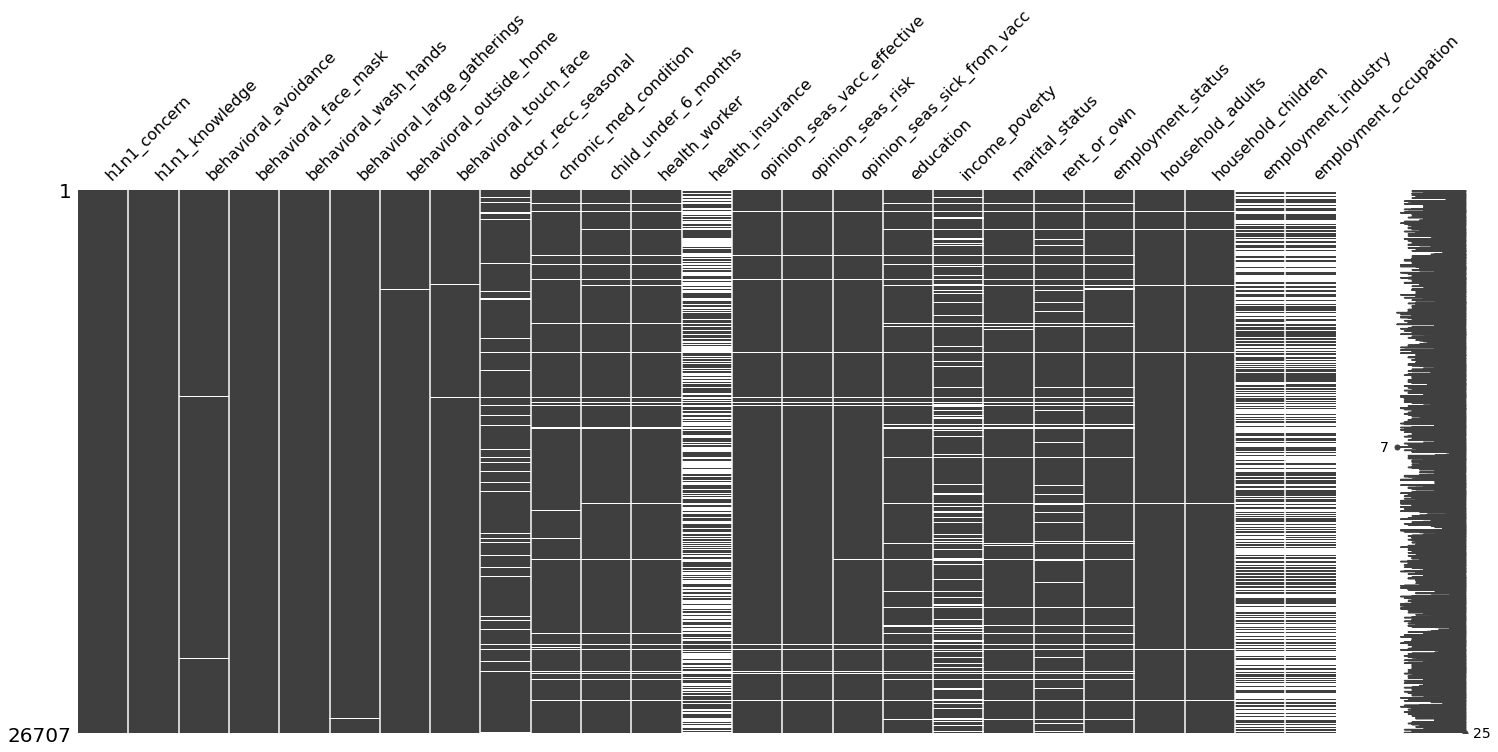

In [336]:
## create a list of cols without any null values to be dropped from missingno.matrix
no_null_cols = [col for col in df.columns if df[col].isna().sum()==0]

## drop columns without missing info to get a clearer view of patterns
missingno.matrix(df.drop(columns=no_null_cols, axis=1))

> - The `employment_occupation`, `employment_industry`, and `health_insurance` columns contain the most missing values, with null values making up 50.4%, 49.9%, and 46.0% of the column, respectively.
 - However, 10,231 of the null values for `employment_occupation` and `employment_industry` are basically 'not applicable' rather than someone declining to answer because those are the respondents who answered 'Not in Labor Force' for `employment_status` (see below).
 - See the same for an additional 1,453 observations representing all unemployed individuals. Again `employment_occupation` and `employment_industry` are better thought of as 'not applicable' rather than someone declining to answer.
- There are some clear patterns in missing values:
  - If respondent declined to answer whether their doctor recommended one type of vaccine, they usually declined to answer about whether their doctor recommended the other.
  - Individuals also seemed to decline to answer whether they had a chronic medical condition, a child under 6 months, whether they were a health worker, all opinion questions, income, education, personal and home life questions in association.
- These trends suggest that missing information for certain variables may be usefully treated as its own category rather than being dropped altogether, since this appears to represent a specific type of respondent that makes up a not insignificant portion of the sample population.

In [337]:
## slice out DataFrame for individuals Not in Labor Force
# not_in_labor_force = df[df['employment_status']=='Not in Labor Force']

## display the number and percent of NaN's in each column
# display(check_null(not_in_labor_force))

## slice out DataFrame for 'Unemployed' individuals
# unemployed = df[df['employment_status']=='Unemployed']

## display the number and percent of NaN's in each column
# check_null(unemployed)

# not_lab_for_ids = list(not_in_labor_force['respondent_id'].index)
# unempl_ids = list(unemployed['respondent_id'].index)
# all_not_employed_ids = not_lab_for_ids + unempl_ids
# len(all_not_employed_ids)

In [338]:
## if a person is unemployed, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Unemployed', 'employment_industry'] = 'not employed'

## if a person is not in the labor force, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Not in Labor Force', 'employment_industry'] = 'not employed'

# check_unique(df, 'employment_industry')

In [339]:
## if a person is unemployed, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Unemployed', 'employment_occupation'] = 'not employed'

## if a person is not in the labor force, change their 'employment_industry' to 'not_employed'
df.loc[df['employment_status'] == 'Not in Labor Force', 'employment_occupation'] = 'not employed'

# check_unique(df, 'employment_occupation')

### Drop Rows Based on Specific Missing Values

In [340]:
# create a DataFrame to show columns with % Null between 0 and 5%
null_df = check_null(df)
null_df.drop(index=null_df.loc[null_df['% Null']==0].index, axis=0, inplace=True)
under_5_null = null_df.loc[null_df['% Null']<5]
under_5_null

,Number of Nulls,% Null
h1n1_concern,92,0.344
h1n1_knowledge,116,0.434
behavioral_avoidance,208,0.779
behavioral_face_mask,19,0.071
behavioral_wash_hands,42,0.157
behavioral_large_gatherings,87,0.326
behavioral_outside_home,82,0.307
behavioral_touch_face,128,0.479
chronic_med_condition,971,3.636
child_under_6_months,820,3.070


In [341]:
## drop records with null values for the above columns, composed of less than 5% null values
under_5_null_cols = list(under_5_null.index)
df.dropna(subset=under_5_null_cols, inplace=True)

## check out the resulting df
display(check_null(df))
df.shape

,Number of Nulls,% Null
h1n1_concern,0,0.000
h1n1_knowledge,0,0.000
behavioral_avoidance,0,0.000
behavioral_face_mask,0,0.000
behavioral_wash_hands,0,0.000
behavioral_large_gatherings,0,0.000
behavioral_outside_home,0,0.000
behavioral_touch_face,0,0.000
doctor_recc_seasonal,1851,7.422
chronic_med_condition,0,0.000


(24939, 31)

<AxesSubplot:>

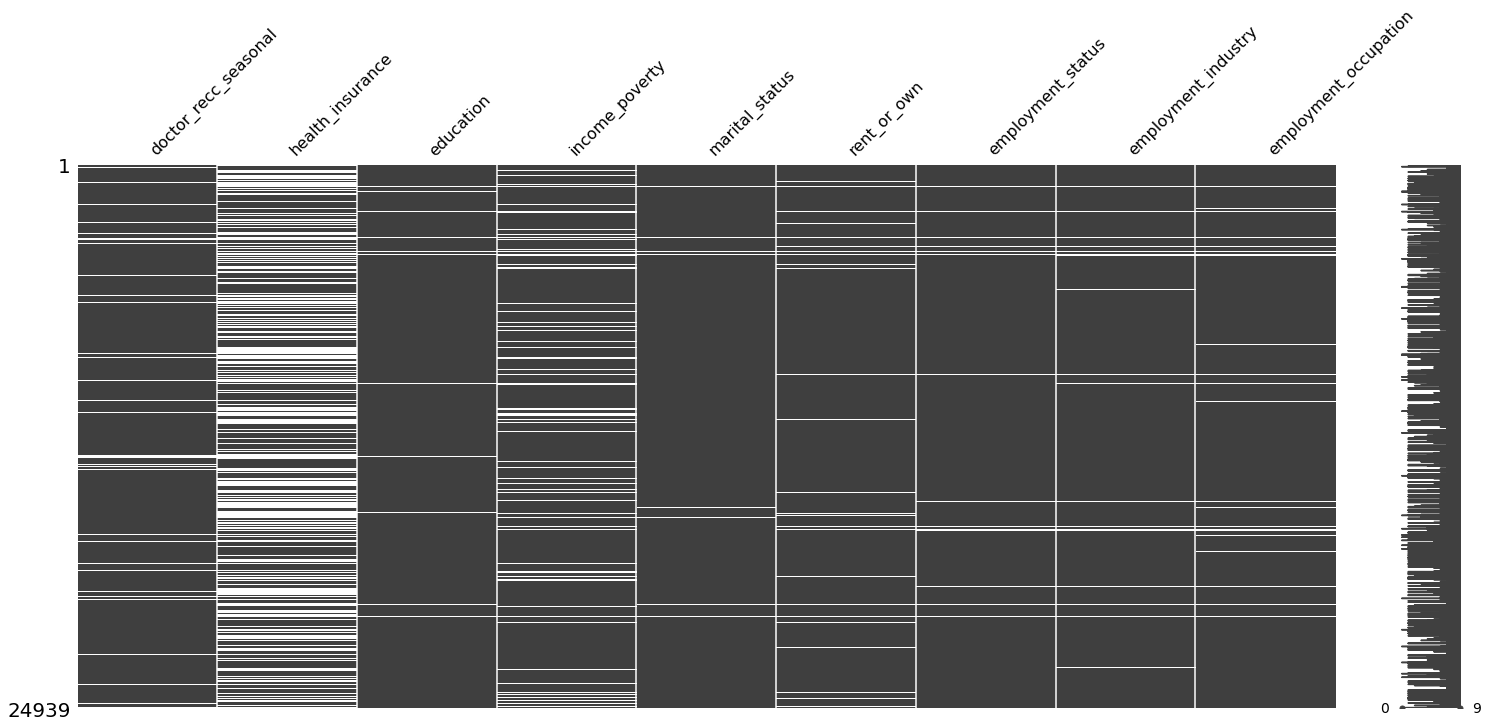

In [342]:
## create a list of cols without any null values to be dropped from missingno.matrix
no_null_cols = [col for col in df.columns if df[col].isna().sum()==0]

## drop columns without missing info to get a clearer view of patterns
missingno.matrix(df.drop(columns=no_null_cols, axis=1))

> - Because nearly half (44.2%) of respondents declined to disclose whether they have `health_insurance`, this 'missing' information will become its own category for this variable.
- The same will be done for the `income_poverty` variable, which is missing 13.4% of its values.
- The pattern of null values is so similar across the variables `education`, `marital_status`, `rent_to_own`, `employment_status`, `employment_industry`, and `employment_occupation` that choosing to drop records containing null values for any of these columns will drop most of the records containing null values for the other columns. Rather than dropping these records, null values for these categorical variables will be filled with 'missing' as its own category since this missing information appears to represent a specific type of survey respondent.
- The `doctor_recc_seasonal` column contains slightly more missing values, and the pattern for this missing information is different compared to the variables mentioned above. Thus null values in this column will be replaced with 'missing' as well.

In [343]:
## print out the counts of unique values appearing in each column, including counts of NaN
for col in df.columns:
    display(check_unique(df, col))

,h1n1_concern
2.000,10017
1.000,7683
3.000,4252
0.000,2987


,h1n1_knowledge
1.000,13767
2.000,9064
0.000,2108


,behavioral_avoidance
1.000,18224
0.000,6715


,behavioral_face_mask
0.000,23245
1.000,1694


,behavioral_wash_hands
1.000,20652
0.000,4287


,behavioral_large_gatherings
0.000,15999
1.000,8940


,behavioral_outside_home
0.000,16549
1.000,8390


,behavioral_touch_face
1.000,17007
0.000,7932


,doctor_recc_seasonal
0.000,15420
1.000,7668
nan,1851


,chronic_med_condition
0.000,17893
1.000,7046


,child_under_6_months
0.000,22866
1.000,2073


,health_worker
0.000,22115
1.000,2824


,health_insurance
1.000,12224
nan,11043
0.000,1672


,opinion_seas_vacc_effective
4.000,11138
5.000,9529
2.000,2099
1.000,1125
3.000,1048


,opinion_seas_risk
2.000,8566
4.000,7350
1.000,5609
5.000,2857
3.000,557


,opinion_seas_sick_from_vacc
1.000,11326
2.000,7280
4.000,4635
5.000,1627
3.000,71


,age_group
65+ Years,6261
55 - 64 Years,5241
45 - 54 Years,4946
18 - 34 Years,4887
35 - 44 Years,3604


,education
College Graduate,9791
Some College,6822
12 Years,5568
< 12 Years,2228
NaN,530


,race
White,19856
Black,1947
Hispanic,1667
Other or Multiple,1469


,sex
Female,14868
Male,10071


,income_poverty
"<= $75,000, Above Poverty",12384
"> $75,000",6668
NaN,3318
Below Poverty,2569


,marital_status
Married,13142
Not Married,11267
NaN,530


,rent_or_own
Own,18124
Rent,5692
NaN,1123


,employment_status
Employed,13192
Not in Labor Force,9761
Unemployed,1408
NaN,578


,hhs_geo_region
lzgpxyit,3964
fpwskwrf,3016
qufhixun,2932
oxchjgsf,2704
bhuqouqj,2680
kbazzjca,2657
mlyzmhmf,2088
lrircsnp,1938
atmpeygn,1933
dqpwygqj,1027


,census_msa
"MSA, Not Principle City",10897
"MSA, Principle City",7275
Non-MSA,6767


,household_adults
1.000,13745
0.000,7449
2.000,2678
3.000,1067


,household_children
0.000,17500
1.000,3030
2.000,2740
3.000,1669


,employment_industry
not employed,11169
fcxhlnwr,2404
wxleyezf,1756
ldnlellj,1192
pxcmvdjn,1009
atmlpfrs,901
arjwrbjb,851
xicduogh,826
NaN,753
mfikgejo,600


,employment_occupation
not employed,11169
xtkaffoo,1729
mxkfnird,1474
emcorrxb,1246
cmhcxjea,1227
xgwztkwe,1053
NaN,879
hfxkjkmi,742
qxajmpny,529
xqwwgdyp,476


,seasonal_vaccine
0,13251
1,11688


> A few key points to note from the above information:
 - The two categories for vaccination status (0 - No Vacc, 1 - Vacc) are relatively balanced within this sample, so class imabalance shouldn't be much of an issue for classifiers.
 - As with so many medical databases, the sample population is predominantly white (19,856 out of 24,939 individuals sampled). Three other categories are included for race: Black, Hispanic, and Other or Multiple. From a modeling perspective it will likely be best to combine these latter three underrepresented groups into one group for people of color. A future direction for this sort of research ought to be more focus on including people of color during data collection, especially in light of how these communities are often disproportionately affected by pandemic outbreaks as seen in the current COVID-19 pandemic. 
 - The sample population is slightly skewed towards women (59.6%).
 - Nearly half of individuals surveyed declined to answer whether or not they had health insurance.

## Feature Engineering

In [344]:
## check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24939 entries, 0 to 26706
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24939 non-null  float64
 1   h1n1_knowledge               24939 non-null  float64
 2   behavioral_avoidance         24939 non-null  float64
 3   behavioral_face_mask         24939 non-null  float64
 4   behavioral_wash_hands        24939 non-null  float64
 5   behavioral_large_gatherings  24939 non-null  float64
 6   behavioral_outside_home      24939 non-null  float64
 7   behavioral_touch_face        24939 non-null  float64
 8   doctor_recc_seasonal         23088 non-null  float64
 9   chronic_med_condition        24939 non-null  float64
 10  child_under_6_months         24939 non-null  float64
 11  health_worker                24939 non-null  float64
 12  health_insurance             13896 non-null  float64
 13  opinion_seas_vac

>- Create a variable that represents how much an individual has done behaviorally to avoid the flu (aside from getting vaccinated) by summing up all behavioral variables. These are all binary columns with 1 representing behavior that reduces the risk of contracting the flu. By taking the sum across these columns, a higher score represents a more careful, flu-conscious/avoidant individual.

,behav_score
5.000,5859
6.000,5240
4.000,4376
7.000,3002
3.000,2668
2.000,1683
8.000,1100
1.000,655
9.000,200
0.000,156


<AxesSubplot:xlabel='behav_score'>

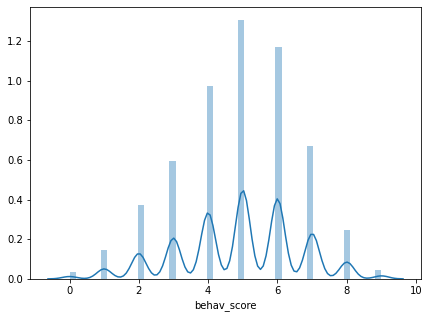

In [345]:
df['behav_score'] = df.iloc[:, :6].sum(axis=1)

## ## check counts of unique values in new col and plot distribution
check_col_distr(df, 'behav_score')

>- Create a variable that represents the ratio of how much an individual has done behaviorally to avoid the flu (aside from getting vaccinated) to their perception of the risk of getting the flu without the vaccine. The numerator is `behav_score` + 1 (min = 1, max = 7) to differentiate among individuals who are not taking any action to avoid the flu, but differ in the degree to which they are concerned about getting sick without the vaccine. The denominator is the rating of risk perception, `opinion_seas_risk` (min = 1, max = 5). An individual with a very low score is someone who has done little to avoid the flu but is very concerned about getting sick without the vaccine. An individual with a score on the upper end has done a lot to behaviorally minimize their risk of exposure and is not very concerned about getting sick without the vaccine. This type of individual may be less likely to get the vaccine, even if they think it's effective, simply because they feel they're doing enough to avoid exposure on their own.

,behav_to_risk
3.000,2951
2.000,2719
1.500,2487
1.750,1914
2.500,1871
3.500,1697
4.000,1693
1.000,1186
5.000,1132
6.000,1125


<AxesSubplot:xlabel='behav_to_risk'>

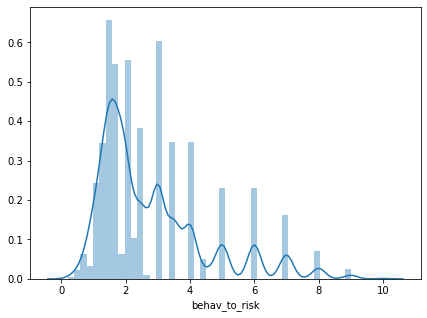

In [346]:
df['behav_to_risk'] = (df['behav_score'] + 1) / df['opinion_seas_risk']

## ## check counts of unique values in new col and plot distribution
check_col_distr(df, 'behav_to_risk')

> - Create a variable for whether or not an individual is 65 years or older as this represents a group at higher risk for serious complications from the flu.

,older_65
0,18678
1,6261


<AxesSubplot:xlabel='older_65'>

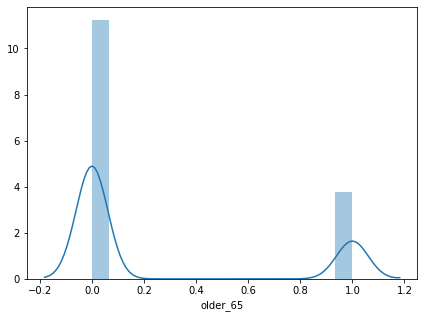

In [347]:
## define a function to return turn 65+ Years or not into a binary variable based on age group
def is_older_65(row):
    if row['age_group'] == '65+ Years':
        return 1
    else:
        return 0

## apply the function to create new column
df['older_65'] = df.apply(lambda x: is_older_65(x), axis=1)

## check counts of unique values in new col and plot distribution
check_col_distr(df, 'older_65')

> - Create a variable that represents an individual's overall risk for developing flu-related complications. Some individuals are naturally at higher risk of developing complications (<a href="https://www.cdc.gov/flu/highrisk/index.htm"> CDC - "People at High Risk for Flu Complications"</a>). This includes people **65 years and older**, **children 6 months or younger** (so people that have regular close contact with a child under 6 months will also be considered higher risk), and people with **chronic medical conditions** (such as asthma or other lung conditions, diabetes, heart conditions, kidney conditions, sickle cell anemia or other anemia, neurological or neuromuscular conditions, liver conditions, or weakened immune systems).

,high_risk_compl
0,12894
1,8852
2,3051
3,142


<AxesSubplot:xlabel='high_risk_compl'>

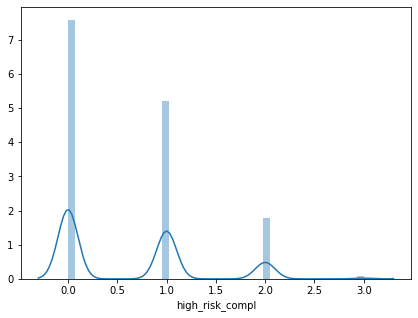

In [348]:
## define a function to calculate score for high risk of complications
def calc_high_risk(row):
    risk = 0
    if row['older_65'] == 1:
        risk += 1
    if row['child_under_6_months'] == 1:
        risk += 1
    if row['chronic_med_condition'] == 1:
        risk += 1
    return risk

## apply the function to create new column
df['high_risk_compl'] = df.apply(lambda x: calc_high_risk(x), axis=1)

## check counts of unique values in new col and plot distribution
check_col_distr(df, 'high_risk_compl')

> - Create a categorical variable that bins individuals with multiple high risk factors (`high_risk_compl` > 1) into one 'high risk' category, assigning 0 to 'low risk' and 1 to 'med risk'.

In [349]:
df['high_risk_cat'] = df['high_risk_compl'].map({0:'low risk', 1:'med risk',
                                                 2:'high risk', 3:'high risk'})

## check counts of unique values in new col
df['high_risk_cat'].value_counts()

low risk     12894
med risk      8852
high risk     3193
Name: high_risk_cat, dtype: int64

In [350]:
## change binary variable from floats to strings without altering NaN values
 ## (NaN will be automatically filled with 'missing' during preprocessing)
df['doctor_recc_seasonal'] = df['doctor_recc_seasonal'].map({1.0: '1', 0.0: '0'})
df['doctor_recc_seasonal'].value_counts(dropna=False)

0      15420
1       7668
NaN     1851
Name: doctor_recc_seasonal, dtype: int64

In [351]:
## change binary variable from floats to strings without altering NaN values
 ## (NaN will be automatically filled with 'missing' during preprocessing)
df['health_insurance'] = df['health_insurance'].map({1.0: '1', 0.0: '0'})
df['health_insurance'].value_counts(dropna=False)

1      12224
NaN    11043
0       1672
Name: health_insurance, dtype: int64

In [352]:
## define a function to return make combine people of color into one category 
 ## since they're so underrepresented in the dataset
def race_func(row):
    if row['race'] == 'White':
        return 'White'
    else:
        return 'POC'

## apply the function to create new column
df['race'] = df.apply(lambda x: race_func(x), axis=1)

## check counts of unique values in new col and plot distribution
df['race'].value_counts(dropna=False)

White    19856
POC       5083
Name: race, dtype: int64

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24939 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24939 non-null  float64
 1   h1n1_knowledge               24939 non-null  float64
 2   behavioral_avoidance         24939 non-null  float64
 3   behavioral_face_mask         24939 non-null  float64
 4   behavioral_wash_hands        24939 non-null  float64
 5   behavioral_large_gatherings  24939 non-null  float64
 6   behavioral_outside_home      24939 non-null  float64
 7   behavioral_touch_face        24939 non-null  float64
 8   doctor_recc_seasonal         23088 non-null  object 
 9   chronic_med_condition        24939 non-null  float64
 10  child_under_6_months         24939 non-null  float64
 11  health_worker                24939 non-null  float64
 12  health_insurance             13896 non-null  object 
 13  opinion_seas_vac

In [354]:
## create df with remaining null values filled in with 'missing' for vizualizations
df_missing = df.fillna(value='missing')
df_missing.head()

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine,behav_score,behav_to_risk,older_65,high_risk_compl,high_risk_cat
0,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0,0.000,0.000,0.000,1,2.000,1.000,2.000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.000,0.000,not employed,not employed,0,1.000,2.000,0,0,low risk
1,3.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0,0.000,0.000,0.000,1,4.000,2.000,4.000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.000,0.000,pxcmvdjn,xgwztkwe,1,7.000,4.000,0,0,low risk
2,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,missing,1.000,0.000,0.000,missing,4.000,1.000,2.000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.000,0.000,rucpziij,xtkaffoo,0,3.000,4.000,0,1,med risk
3,1.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1,1.000,0.000,0.000,missing,5.000,4.000,1.000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.000,0.000,not employed,not employed,1,5.000,1.500,1,2,high risk
4,2.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,0,0.000,0.000,0.000,missing,3.000,1.000,4.000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.000,0.000,wxleyezf,emcorrxb,0,6.000,7.000,0,0,low risk


## Train Test Split and Preprocessing

In [355]:
## import function needed for split
from sklearn.model_selection import train_test_split

## import classes necessary for building preprocessing pipelines
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [356]:
## define a list of intermediate engineered features that will be highly correlated
 ## with other features
feats_to_drop = ['older_65', 'high_risk_compl']

## drop those features from the df
df.drop(columns=feats_to_drop, axis=1, inplace=True)

In [357]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,seasonal_vaccine,behav_score,behav_to_risk,high_risk_cat
0,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0,0.000,0.000,0.000,1,2.000,1.000,2.000,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.000,0.000,not employed,not employed,0,1.000,2.000,low risk
1,3.000,2.000,1.000,0.000,1.000,0.000,1.000,1.000,0,0.000,0.000,0.000,1,4.000,2.000,4.000,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.000,0.000,pxcmvdjn,xgwztkwe,1,7.000,4.000,low risk
2,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,NaN,1.000,0.000,0.000,NaN,4.000,1.000,2.000,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.000,0.000,rucpziij,xtkaffoo,0,3.000,4.000,med risk
3,1.000,1.000,1.000,0.000,1.000,1.000,0.000,0.000,1,1.000,0.000,0.000,NaN,5.000,4.000,1.000,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.000,0.000,not employed,not employed,1,5.000,1.500,high risk
4,2.000,1.000,1.000,0.000,1.000,1.000,0.000,1.000,0,0.000,0.000,0.000,NaN,3.000,1.000,4.000,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.000,0.000,wxleyezf,emcorrxb,0,6.000,7.000,low risk


In [358]:
## need to process numerical and categorical variables differently, 
 # but right now some categorical variables are still showing up as numeric because NaNs 
 # haven't been filled in with 'missing' (this will be done as part of preprocessing pipeline)
null_df = check_null(df)
miss_val_cols = list(null_df.loc[null_df['% Null']>0].index)
miss_val_cols 
# these all need to have null values filled with 'missing'
# so they will all be categorical if they aren't already

['doctor_recc_seasonal',
 'health_insurance',
 'education',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'employment_industry',
 'employment_occupation']

In [360]:
## make a list of all columns that are currently object dtype
obj_cols = list(df.select_dtypes('O').columns)
## add to that list the columns with missing values that will become categorical when 'missing' imputed
 # use set() so no column appears twice in the list since there's some overlap
cat_cols = list(set(obj_cols + miss_val_cols))
cat_cols

['race',
 'health_insurance',
 'income_poverty',
 'age_group',
 'sex',
 'employment_occupation',
 'rent_or_own',
 'high_risk_cat',
 'doctor_recc_seasonal',
 'marital_status',
 'education',
 'employment_status',
 'census_msa',
 'hhs_geo_region',
 'employment_industry']

In [361]:
## columns to be treated as numeric in pipeline are all the remaining cols in X 
 # that are not in cat_cols
num_cols = [col for col in df.drop('seasonal_vaccine', axis=1).columns if col not in cat_cols]
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'behav_score',
 'behav_to_risk']

In [362]:
## define target variable
target = 'seasonal_vaccine'

## separate of features (X) and target (y) for train-test-split
X = df.drop(columns=target, axis=1).copy()
y = df[target].copy()

## define random seed to use for train test split and later for classifiers for reproducibility
random_seed = 319

## split the data into training and test sets prior to preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_seed)

## check for class imbalance across all sets of y
print('**original**\n', y.value_counts(normalize=True), '\n------\n')
print('**y_train**\n', y_train.value_counts(normalize=True), '\n------\n')
print('**y_test**\n', y_test.value_counts(normalize=True), '\n------\n')

**original**
 0   0.531
1   0.469
Name: seasonal_vaccine, dtype: float64 
------

**y_train**
 0   0.532
1   0.468
Name: seasonal_vaccine, dtype: float64 
------

**y_test**
 0   0.528
1   0.472
Name: seasonal_vaccine, dtype: float64 
------



In [363]:
## create a pipeline for transforming numerical columns
num_transformer = Pipeline(steps = [('scaler', StandardScaler())])
num_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [364]:
## create a pipeline for transforming categorical columns
# cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='constant', fill_value='missing'))])

cat_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                    ('encoder', OneHotEncoder(handle_unknown='error', 
                                                              sparse=False,
                                                              drop='if_binary'))])
cat_transformer

Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value='missing', strategy='constant')),
                ('encoder', OneHotEncoder(drop='if_binary', sparse=False))])

In [365]:
## combine num and cat transformer pipelines into a single preprocessing pipeline
preprocessing = ColumnTransformer(transformers=[('num', num_transformer, num_cols),
                                                ('cat', cat_transformer, cat_cols)])
preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'chronic_med_condition',
                                  'child_under_6_months', 'health_worker',
                                  'opinion_seas_vacc_...
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('encoder',
                          

In [366]:
## preprocess training and test data
X_train_tf = preprocessing.fit_transform(X_train)
X_test_tf = preprocessing.transform(X_test)
# X_train_tf

In [367]:
## get the feature names in the order they appear in preprocessed data
feature_names = preprocessing.named_transformers_['cat'].named_steps['encoder'].get_feature_names(cat_cols)
feature_names = np.r_[num_cols, feature_names]
# feature_names
# len(feature_names)

# EXPLORE

## Investigate Variable Distributions and Relationship with Target

In [368]:
## print summary statistics for columns
df.describe()

,h1n1_concern,h1n1_knowledge,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,seasonal_vaccine,behav_score,behav_to_risk
count,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000,24939.000
mean,1.623,1.279,0.731,0.068,0.828,0.358,0.336,0.682,0.283,0.083,0.113,4.036,2.731,2.116,0.894,0.542,0.469,4.887,2.791
std,0.903,0.608,0.444,0.252,0.377,0.480,0.472,0.466,0.450,0.276,0.317,1.080,1.387,1.332,0.752,0.932,0.499,1.730,1.696
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.200
25%,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,4.000,2.000,1.000,0.000,0.000,0.000,4.000,1.500
50%,2.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,4.000,2.000,2.000,1.000,0.000,0.000,5.000,2.250
75%,2.000,2.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,0.000,0.000,5.000,4.000,4.000,1.000,1.000,1.000,6.000,3.500
max,3.000,2.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,5.000,5.000,5.000,3.000,3.000,1.000,9.000,10.000


Trends within dataset as shown by summary statistics (above) and variable distributions (below):
- **Target variable - `seasonal_vaccine`:** The sample population is nearly evenly split with 46.9% of respondents being vaccinated and 53.1% not receiving the seasonal flu vaccine during the survey year (2009).

- **Independent variables:**
    - Respondents were more likely to report that they've taken what might be viewed as less extreme measures to reduce their risk of contracting the seasonal flu virus such as avoiding close contact with people exhibiting flu-like symptoms (`behavioral_avoidance` - 73% of respondents), washing their hands frequently (`behavioral_wash_hands` - 83%), and to a lesser extent avoiding touching their face (`behavioral_touch_face` - 68%).
    - Respondents very infrequently engaged in more extreme measures to avoid contracting the flu such as purchasing a face mask to wear (`behavioral_face_mask` - 7%), avoiding large gatherings (`behavioral_large_gatherings` - 36%), and reducing contact with people outside their own homes (`behavioral_outside_home` - 34%).
    - 28% of respondents have a chronic medical condition (`chronic_med_condition`) that puts them at high risk for developing flu-related complications.
    - The majority of respondents believe the flu vaccine to be at least somewhat effective (`opinion_seas_vacc_effective`) at protecting against the flu (mean rating ~4: somewhat effective).
    - The sample population is relatively evenly split on opinions about their risk of contracting the flu without the vaccine (`opinion_seas_risk`), with few respondents expressing no opinion on their risk.
    - 11% of the sample population are health workers (`health_worker`).


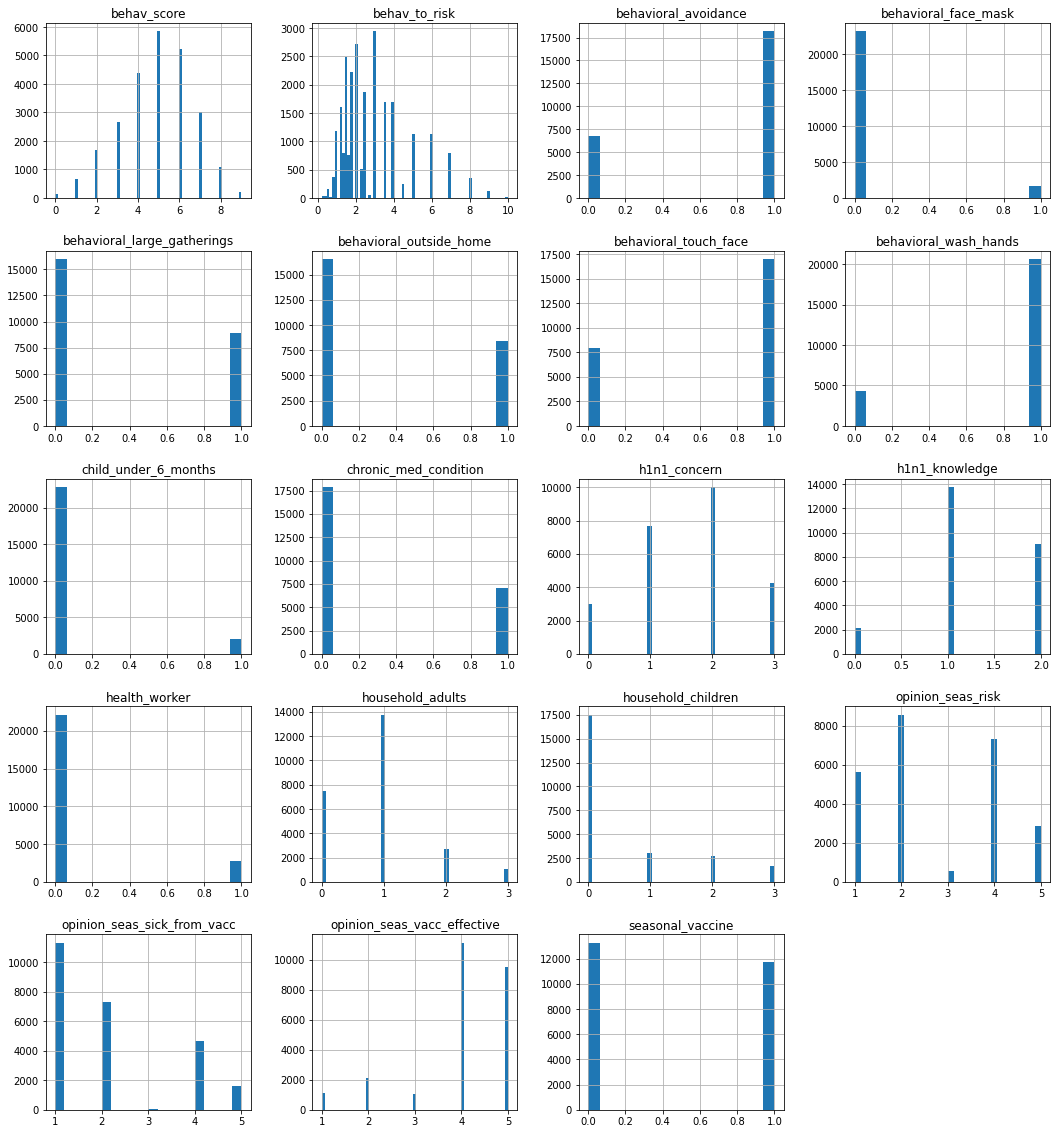

In [369]:
## display histograms for all variables and target
df.hist(figsize=(18, 20), bins='auto');

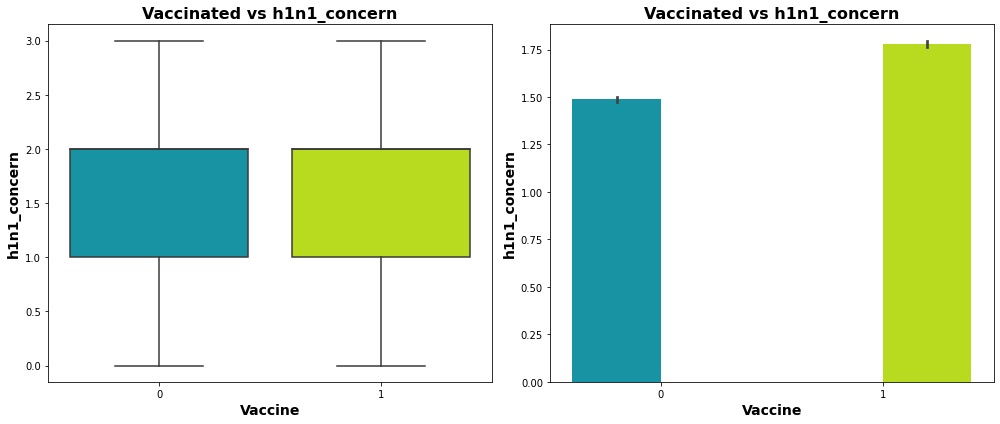

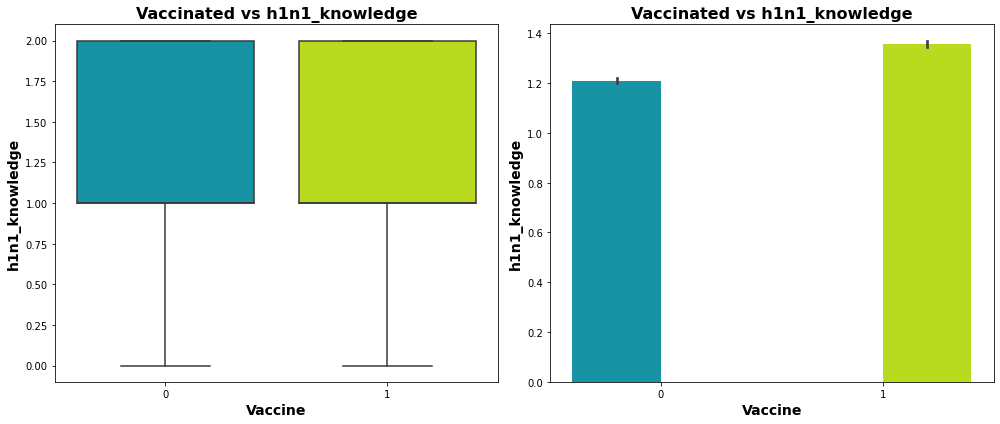

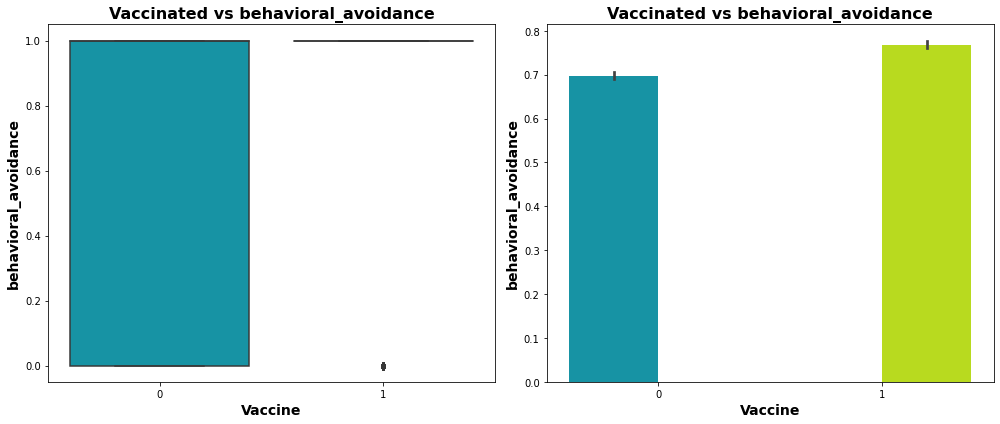

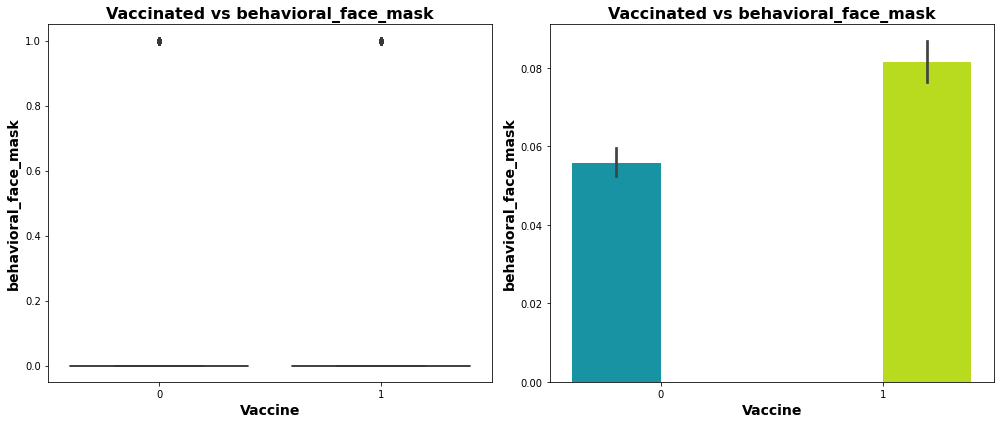

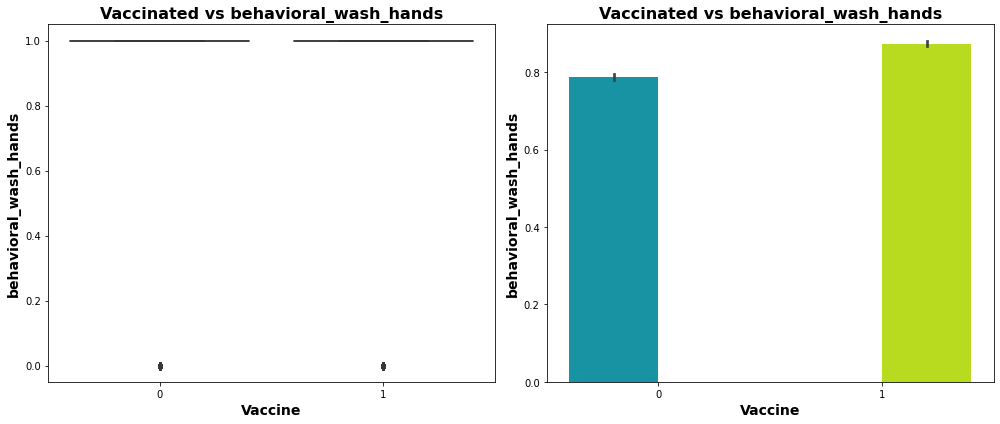

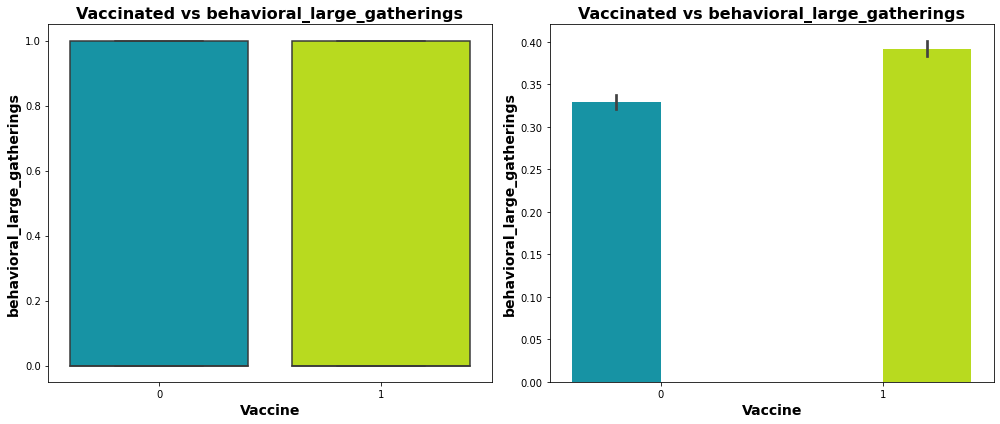

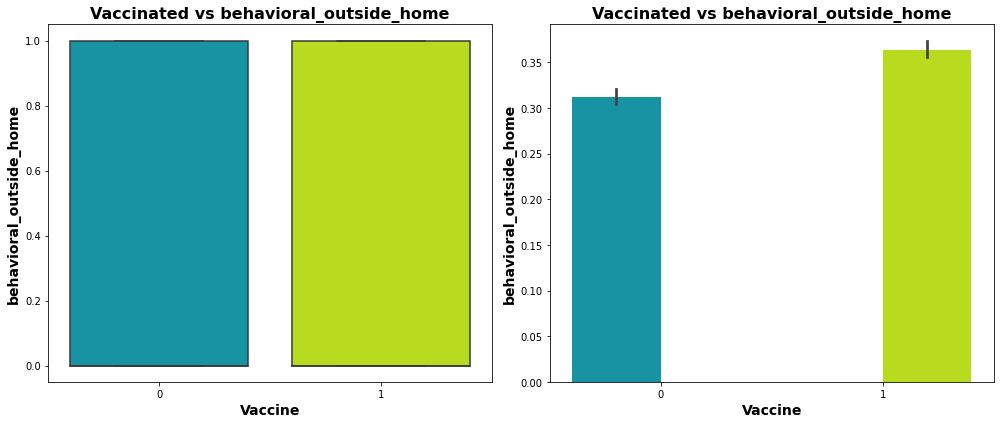

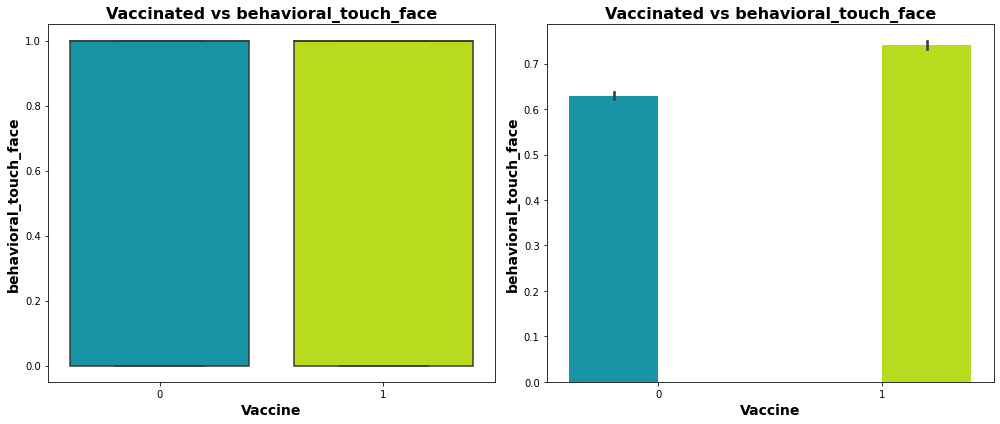

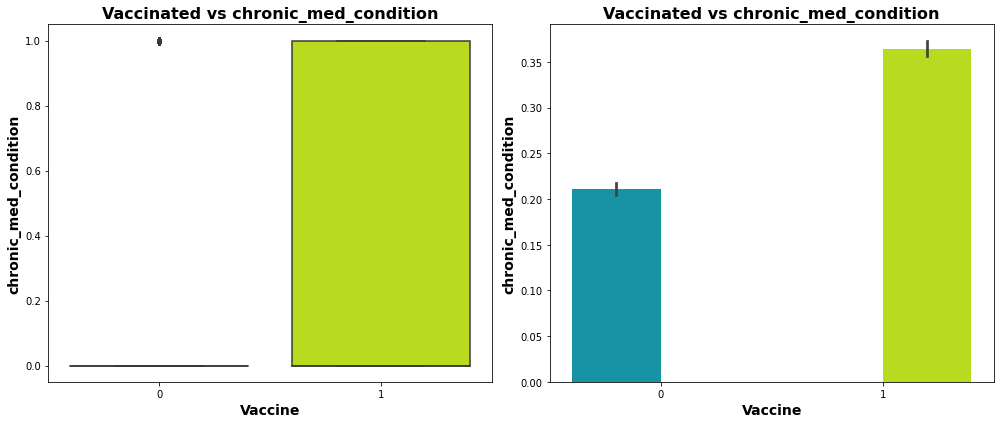

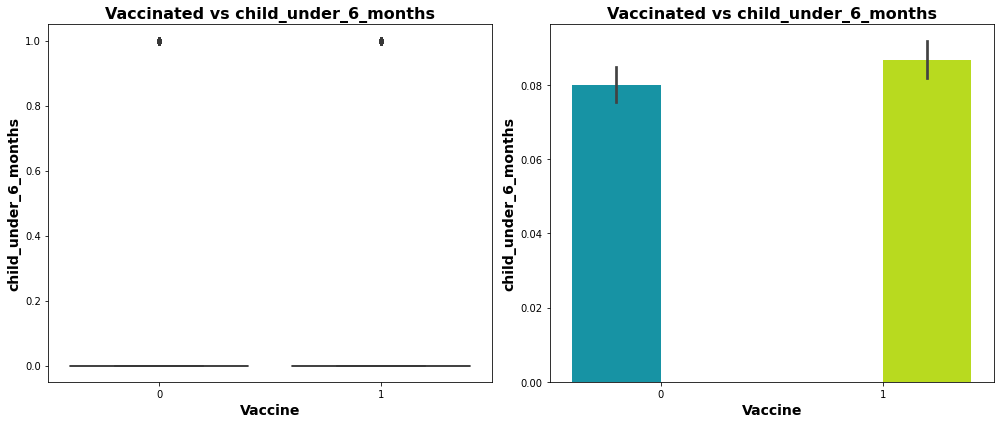

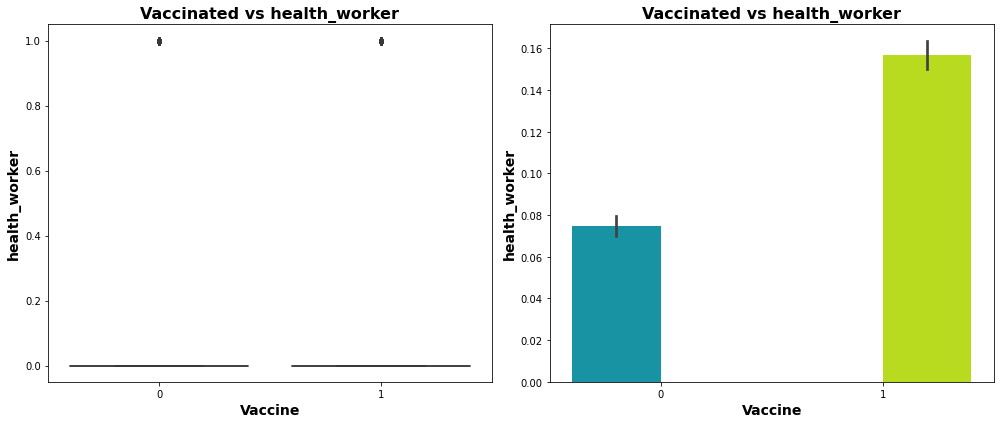

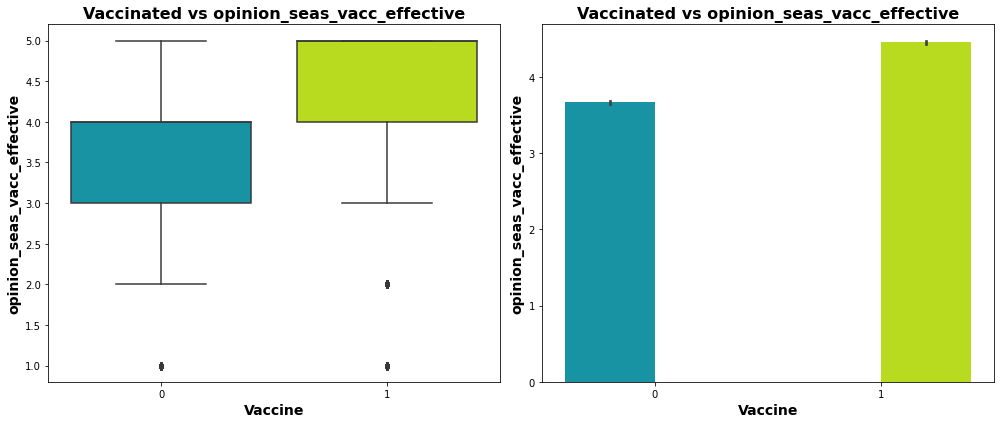

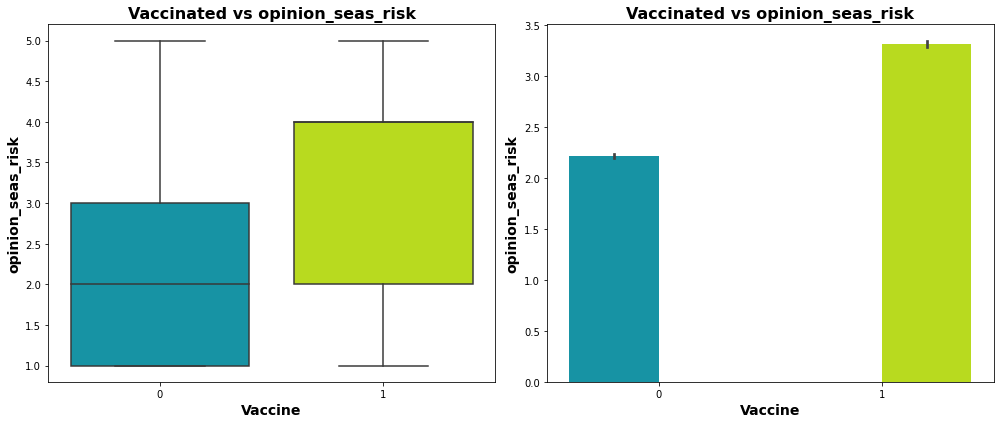

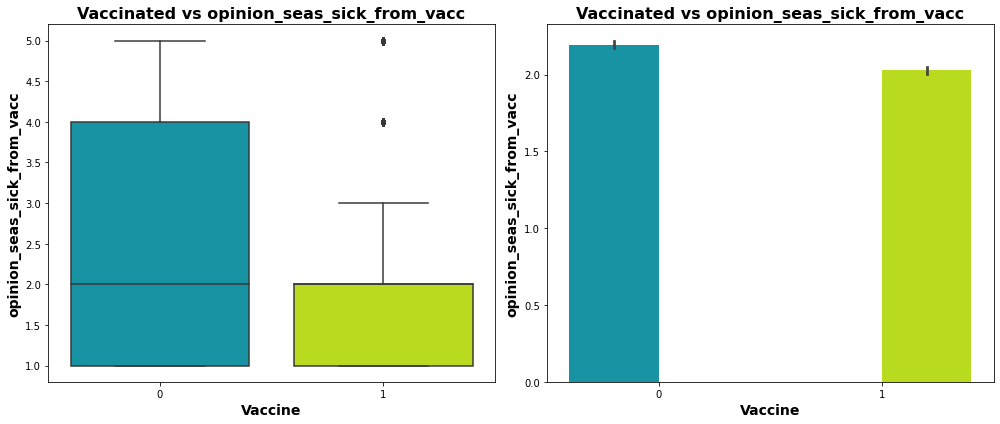

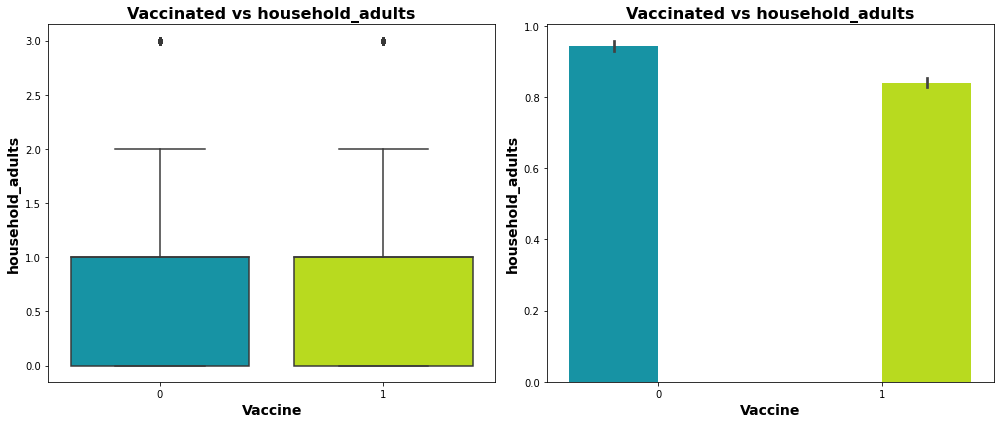

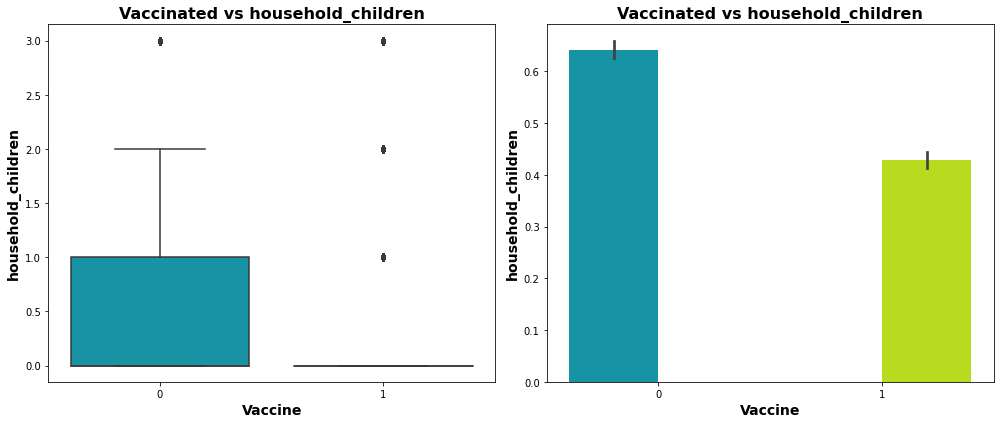

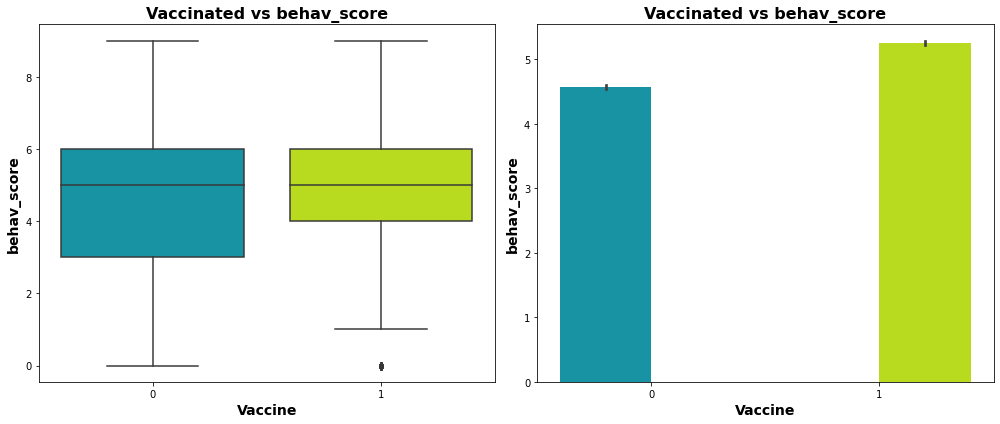

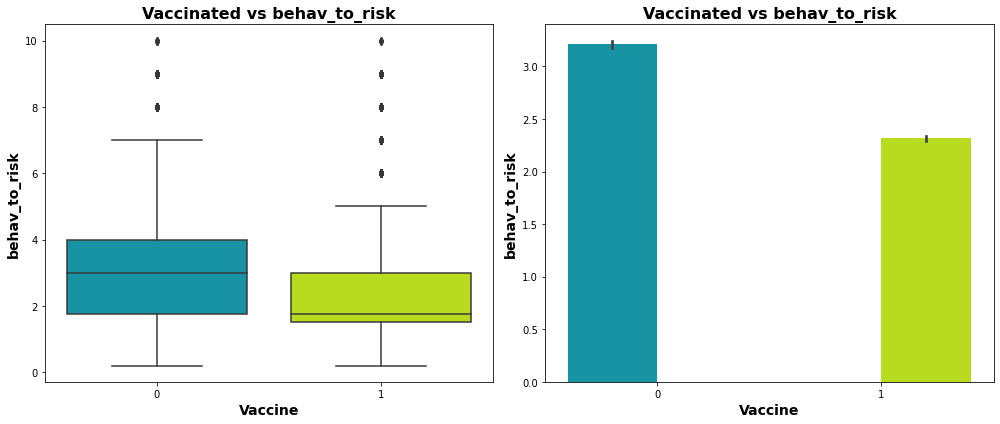

In [370]:
## make a list of categorical columns from the full df with engineered features
df_cat_cols = [col for col in df.columns if df[col].dtype == 'object']

## drop the categorical columns and plot a boxplot and bar plot for each numerical col
  ## plotted against the target variable 'seasonal_vaccine'
for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
    plot_bb(col, df)

> - There appears to be a reasonable amount of variation in most of the variables plotted above, and the majority of them seem to differ at least a little between those who got the vaccine and those who did not. Thus, these variables will all be included as predictors in initial models.

## Investigate Potential Interaction Effects

> - No substantial interaction effects were found, so these features do not need to be engineered.

In [371]:
# # check for interaction effects between sex and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='sex')

> - No obvious interactions between `sex` and other variables on whether someone gets the vaccine. The direction of the difference between males and females remains consistent across those not getting the vaccine and those that do get vaccinated.

In [372]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='education')

> - While some of the lines for different levels of education do cross going from not vaccinated to vaccinated, there are no variables for which this interaction makes a substanial difference among education levels. If the lines do cross, they stay very close together and don't show much separation. As such no interaction features for education will be considered.

In [455]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='race')

> - While some of the lines for different levels of education do cross going from not vaccinated to vaccinated, there are no variables for which this interaction makes a substanial difference among education levels. If the lines do cross, they stay very close together and don't show much separation. As such no interaction features for education will be considered.

In [374]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='age_group')

> - No obvious interactions between `age_group` and other variables on whether someone gets the vaccine. The direction of the difference among groups remains consistent across those not getting the vaccine and those that do get vaccinated.

In [375]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='income_poverty')

> - No obvious interactions between `income_poverty` and other variables on whether someone gets the vaccine. The direction of the difference among groups remains consistent across those not getting the vaccine and those that do get vaccinated.

In [376]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='employment_status')

> - No obvious interactions between `employment_status` and other variables on whether someone gets the vaccine. The direction of the difference among groups remains consistent across those not getting the vaccine and those that do get vaccinated.

In [377]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='health_insurance')

> - No obvious interactions between `health_insurance` and other variables on whether someone gets the vaccine. The direction of the difference among groups remains consistent across those not getting the vaccine and those that do get vaccinated.

In [378]:
# # check for interaction effects between education and other variables
# for col in df.drop(columns=[*df_cat_cols, 'seasonal_vaccine'], axis=1).columns:
#     plot_reg(col, df, category='doctor_recc_seasonal')

> - No obvious interactions between `doctor_recc_seasonal` and other variables on whether someone gets the vaccine. The direction of the difference among groups remains consistent across those not getting the vaccine and those that do get vaccinated.

## Investigate Correlation Among Variables

> - As shown below, very few of the variables are highly correlated. The `behav_score` variable is unsurprisingly correlated with the behavioral metrics that went into calculating the score, but the correlation coefficients are not extremely high (all less than 0.6). However, `behav_score` is fairly highly correlated with `h1n1_concern` (0.76) and the `behav_to_risk` ratio variable is fairly highly correlated with its denominator `opinion_seas_risk`. These correlations should not be a major issue since there are only a couple and more complex models such as Random Forest and XGB Classifiers are able to handle multicollinearity fairly well.


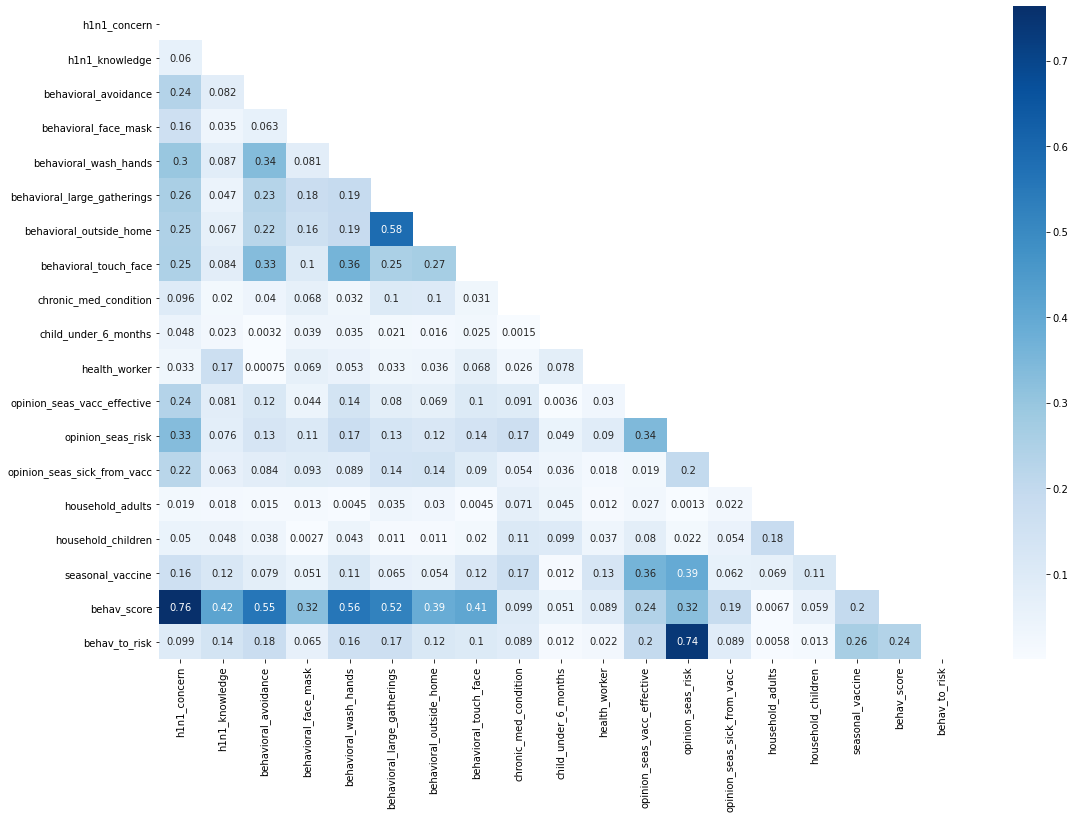

In [379]:
## plot correlations among variables as an annotated heatmap
corr = df.corr().abs()
mask = np.zeros_like(corr)

## mask the correlations of the variables with themselves along the diagonal and all duplicate
 ## correlations to the right of that line
mask[np.triu_indices_from(mask)] = True
mask
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap='Blues', mask=mask);

# MODEL

## Logistic Regression

In [380]:
from sklearn.linear_model import LogisticRegression

### Baseline Logistic Regression

> - First fit a baseline logistic regression model with default parameters and evaluate its performance.

In [381]:
## Use preprocessor as the first step in Logistic Regression modeling Pipeline 
logreg = Pipeline(steps=[('preprocessing', preprocessing),
                          ('logreg', LogisticRegression(solver='sag', random_state=random_seed))])

logreg.fit(X_train, y_train)

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'chronic_med_condition',
                                                   'child_under_6_mont

------------------------------------------------------------------------
Classification Report: Baseline Logistic Regression with Default Params
------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.80      0.80      3295
     Vaccine       0.78      0.77      0.77      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

------------------------------------------------------------------------
------------------------------------------------------------------------




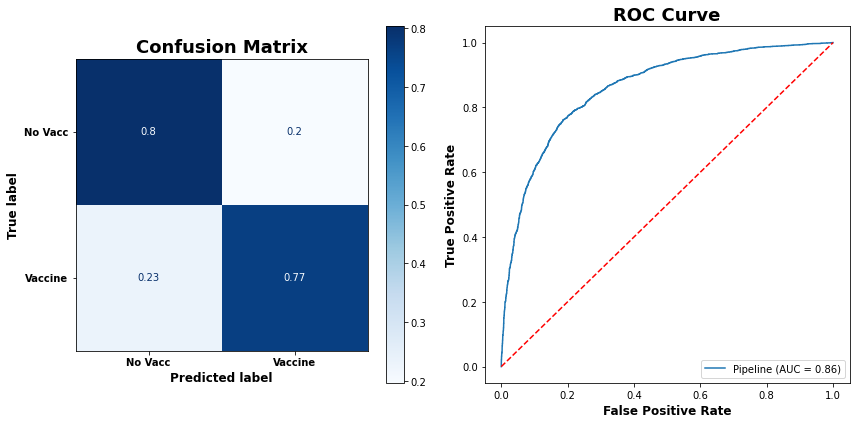

In [382]:
eval_classifier(logreg, X_test, y_test, model_descr='Baseline Logistic Regression with Default Params')

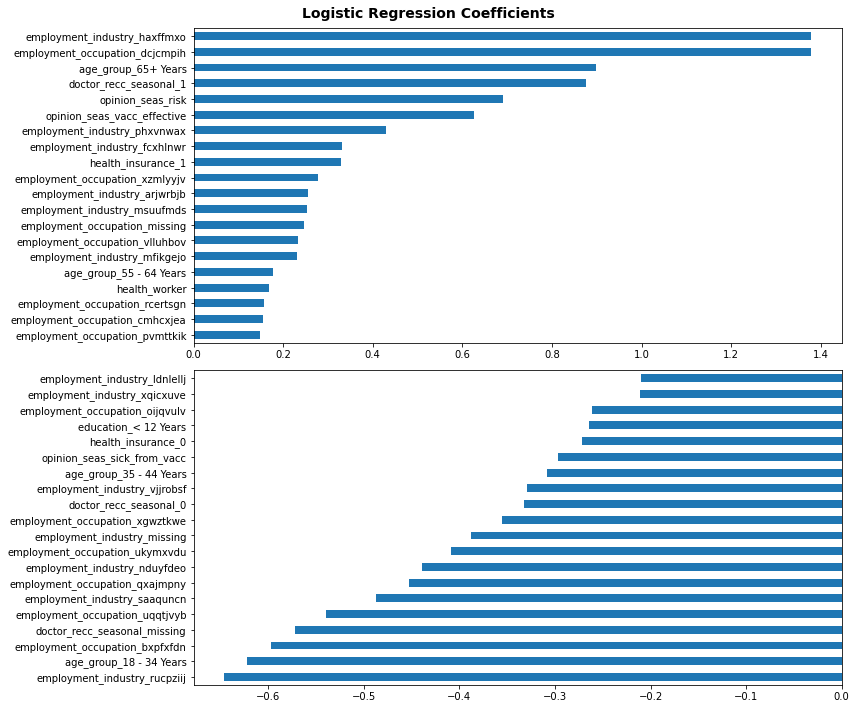

In [383]:
plot_logreg_coeffs(logreg, feature_names)

### GridSearch Logistic Regression Hyperparameters

In [384]:
from sklearn.model_selection import GridSearchCV

#### Select Best Classifier Based on 'recall_macro'

> - Now use GridSearch to tune a logistic regression model to optimize 'recall_macro' (average of the true positive rate for both classes) and evaluate its performance.

In [385]:
## define a grid of different hyperparameter values to be tested
params ={'logreg__C':[0, 1e-10, 1e-5, 1e-1, 1],
         'logreg__fit_intercept':[True, False],
         'logreg__class_weight':[None,'balanced']
        }

## run the grid search to test parameters and find the best estimator 
rec_macro_logreg_grid = fit_grid_clf(logreg, params, X_train, y_train, score='recall_macro')

## print parameters from best estimator
rec_macro_logreg_grid.best_params_

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'logreg__C': 1, 'logreg__class_weight': None, 'logreg__fit_intercept': True}

---------------------------------------------------------------------------
Classification Report: GridSearch Tuned Logistic Regression - Recall Macro
---------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.80      0.80      3295
     Vaccine       0.78      0.77      0.77      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

---------------------------------------------------------------------------
---------------------------------------------------------------------------




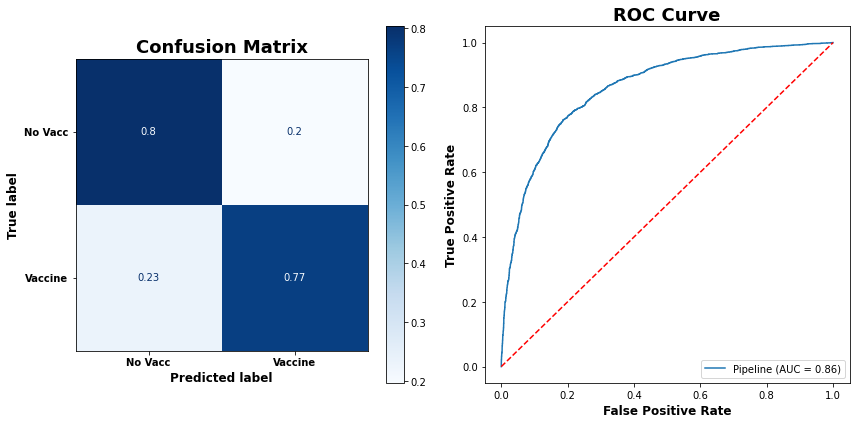

In [386]:
eval_classifier(rec_macro_logreg_grid.best_estimator_, X_test, y_test,
                model_descr='GridSearch Tuned Logistic Regression - Recall Macro')

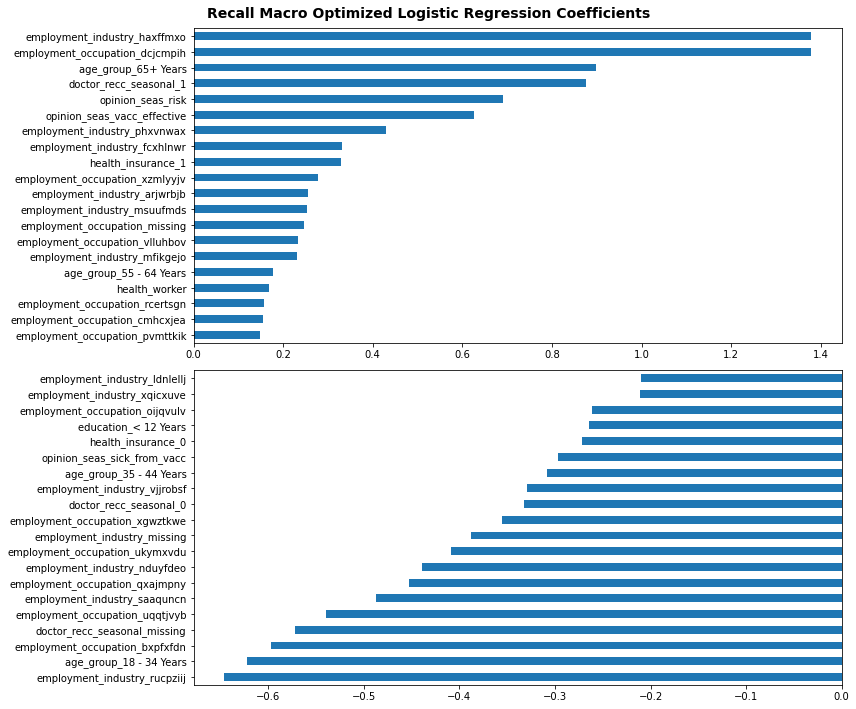

In [387]:
plot_logreg_coeffs(rec_macro_logreg_grid.best_estimator_, feature_names,
                   title='Recall Macro Optimized Logistic Regression Coefficients')

#### Select Best Classifier Based on 'accuracy'

> - Now use GridSearch to tune a logistic regression model to optimize 'accuracy' (percentage of correct predictions out of total) and evaluate its performance.

In [388]:
## define a grid of different hyperparameter values to be tested
params ={'logreg__C':[0, 1e-10, 1e-5, 1e-1, 1],
         'logreg__fit_intercept':[True, False],
         'logreg__class_weight':[None,'balanced']
        }

## run the grid search to test parameters and find the best estimator 
acc_logreg_grid = fit_grid_clf(logreg, params, X_train, y_train)

## print parameters from best estimator
acc_logreg_grid.best_params_

/Users/maxsteele/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


{'logreg__C': 1, 'logreg__class_weight': None, 'logreg__fit_intercept': True}

-----------------------------------------------------------------------
Classification Report: GridSearch Tuned Logistic Regression - Accuracy
-----------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.80      0.80      3295
     Vaccine       0.78      0.77      0.77      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-----------------------------------------------------------------------
-----------------------------------------------------------------------




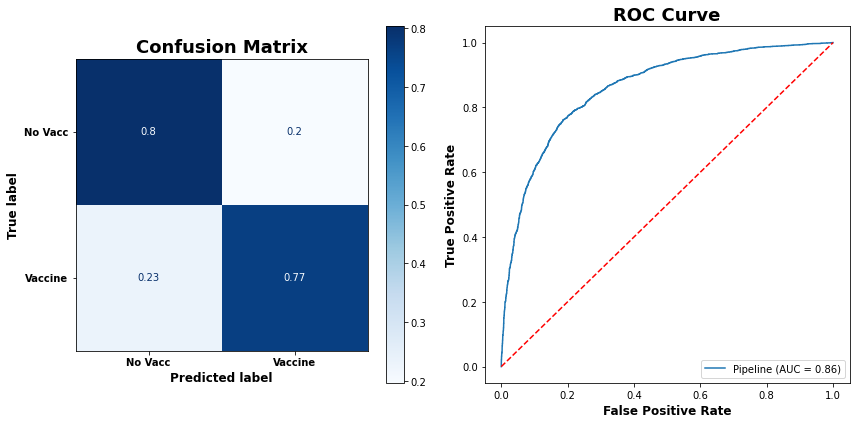

In [389]:
eval_classifier(acc_logreg_grid.best_estimator_, X_test, y_test,
                model_descr='GridSearch Tuned Logistic Regression - Accuracy')

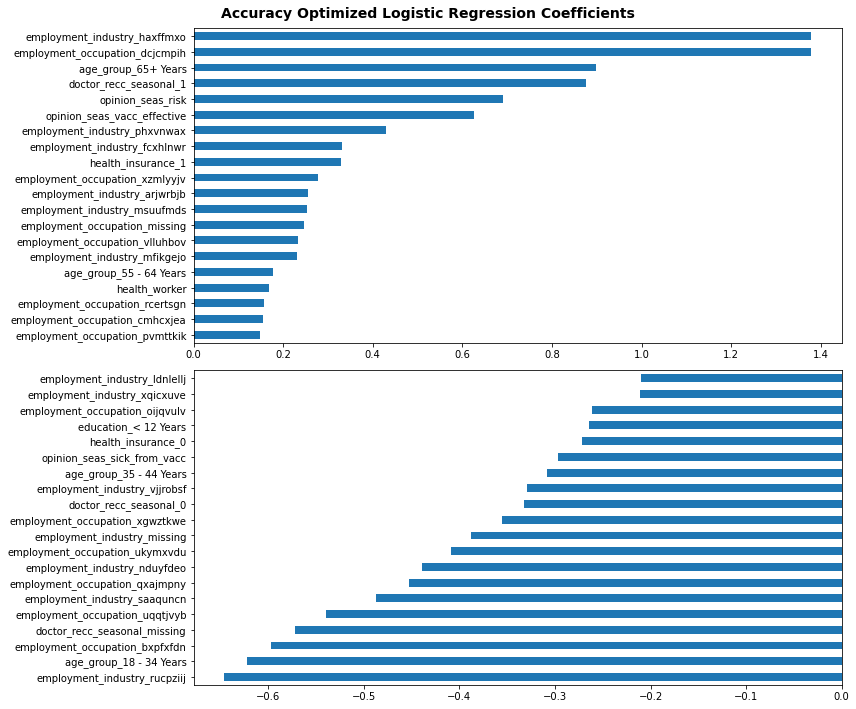

In [390]:
plot_logreg_coeffs(acc_logreg_grid.best_estimator_, feature_names,
                   title='Accuracy Optimized Logistic Regression Coefficients')

> - Performance metrics such as precision, recall, accuracy, f1 score, and ROC AUC did not improve with tuning.

## Decision Trees

In [391]:
from sklearn.tree import DecisionTreeClassifier

### Baseline Decision Tree

> - First fit a baseline decision tree model with default parameters and evaluate its performance.

In [392]:
## Use preprocessor as the first step in modeling Pipeline 
dt = Pipeline(steps=[('preprocessing',preprocessing),
                          ('dt', DecisionTreeClassifier(random_state=random_seed))])

dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'chronic_med_condition',
                                                   'child_under_6_mont

------------------------------------------------------------------
Classification Report: Baseline Decision Tree with Default Params
------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.72      0.70      0.71      3295
     Vaccine       0.68      0.70      0.69      2940

    accuracy                           0.70      6235
   macro avg       0.70      0.70      0.70      6235
weighted avg       0.70      0.70      0.70      6235

------------------------------------------------------------------
------------------------------------------------------------------




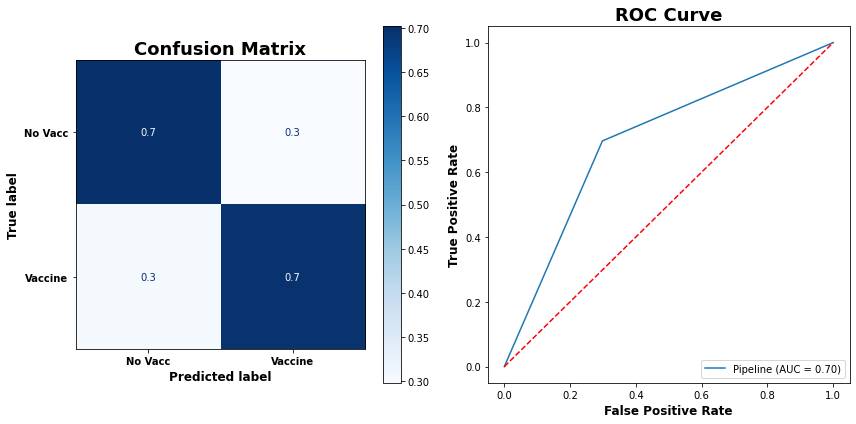

In [393]:
eval_classifier(dt, X_test, y_test, model_descr='Baseline Decision Tree with Default Params')

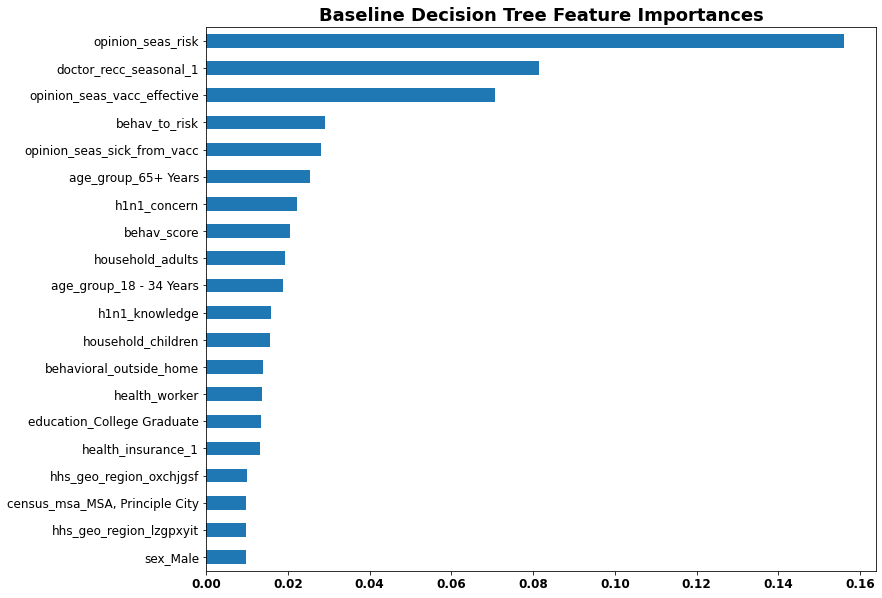

In [394]:
plot_feat_importance(dt, 'dt', feature_names, model_title='Baseline Decision Tree')

### GridSearch Decision Tree Hyperparameters

#### Select Best Classifier Based on 'recall_macro'

> - Now use GridSearch to tune a decision tree classifier to optimize 'recall_macro' (average of the true positive rate for both classes) and evaluate its performance.

In [395]:
## define a grid of different hyperparameter values to be tested
params ={'dt__criterion':['gini', 'entropy'],
         'dt__max_depth':[None, 3, 6, 9],
         'dt__class_weight':[None, 'balanced'],
         'dt__min_samples_split':[10, 50, 100, 500],
         'dt__max_features':[None, 'sqrt', 'log2']
        }

## run the grid search to test parameters and find the best estimator
rec_macro_dt_grid = fit_grid_clf(dt, params, X_train, y_train, score='recall_macro')

## print parameters from best estimator
rec_macro_dt_grid.best_params_

{'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 9,
 'dt__max_features': None,
 'dt__min_samples_split': 100}

------------------------------------------------------------
Classification Report: Recall Macro Optimized Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.78      0.78      3295
     Vaccine       0.75      0.76      0.76      2940

    accuracy                           0.77      6235
   macro avg       0.77      0.77      0.77      6235
weighted avg       0.77      0.77      0.77      6235

------------------------------------------------------------
------------------------------------------------------------




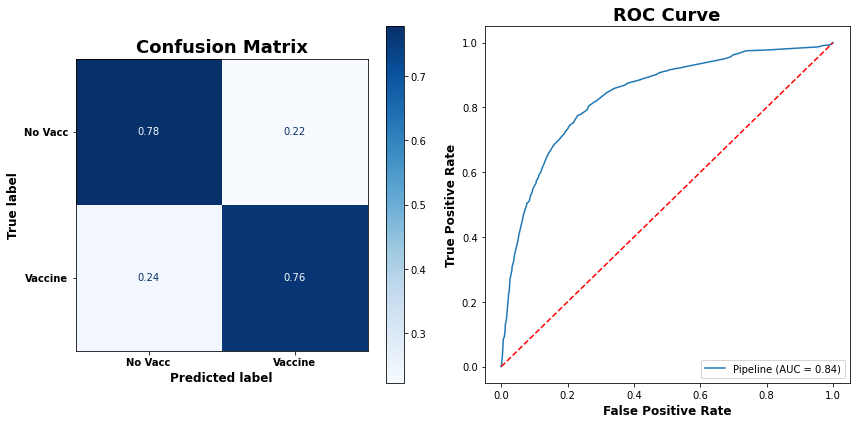

In [396]:
eval_classifier(rec_macro_dt_grid.best_estimator_, X_test, y_test,
                model_descr='Recall Macro Optimized Decision Tree')

In [397]:
rec_macro_dt_grid.best_estimator_.named_steps['dt']

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_split=100, random_state=319)

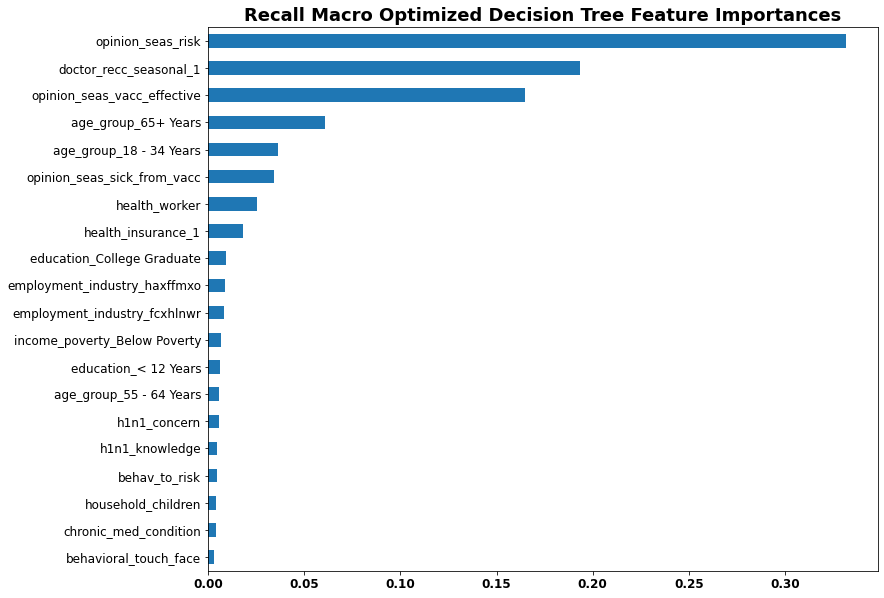

In [398]:
plot_feat_importance(rec_macro_dt_grid.best_estimator_, 'dt', feature_names,
                     model_title='Recall Macro Optimized Decision Tree')

#### Select Best Classifier Based on 'accuracy'

In [399]:
## define a grid of different hyperparameter values to be tested
params ={'dt__criterion':['gini', 'entropy'],
         'dt__max_depth':[None, 3, 6, 9],
         'dt__class_weight':[None, 'balanced'],
         'dt__min_samples_split':[10, 50, 100, 500],
         'dt__max_features':[None, 'sqrt', 'log2']
        }

## run the grid search to test parameters and find the best estimator 
acc_dt_grid = fit_grid_clf(dt, params, X_train, y_train)

## print parameters from best estimator
acc_dt_grid.best_params_

{'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 9,
 'dt__max_features': None,
 'dt__min_samples_split': 100}

In [400]:
acc_dt_grid.best_estimator_.named_steps['dt']

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_split=100, random_state=319)

-------------------------------------------------------------------
Classification Report: Accuracy Optimized GridSearch Decision Tree
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.78      0.78      3295
     Vaccine       0.75      0.76      0.76      2940

    accuracy                           0.77      6235
   macro avg       0.77      0.77      0.77      6235
weighted avg       0.77      0.77      0.77      6235

-------------------------------------------------------------------
-------------------------------------------------------------------




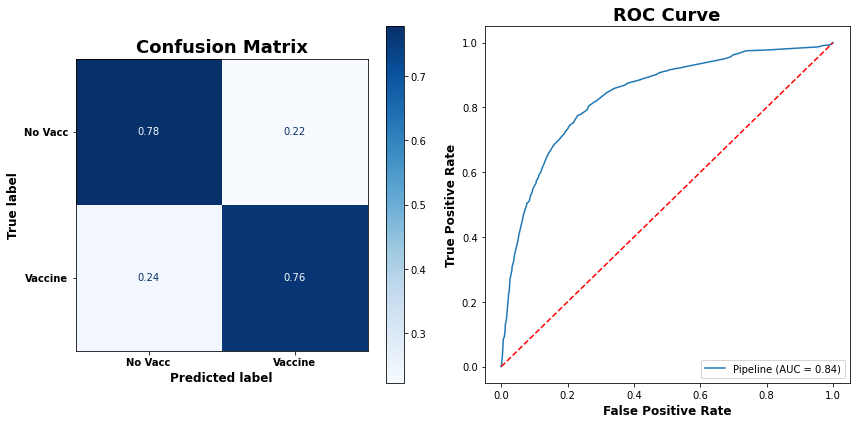

In [401]:
eval_classifier(acc_dt_grid.best_estimator_, X_test, y_test,
                model_descr='Accuracy Optimized GridSearch Decision Tree')

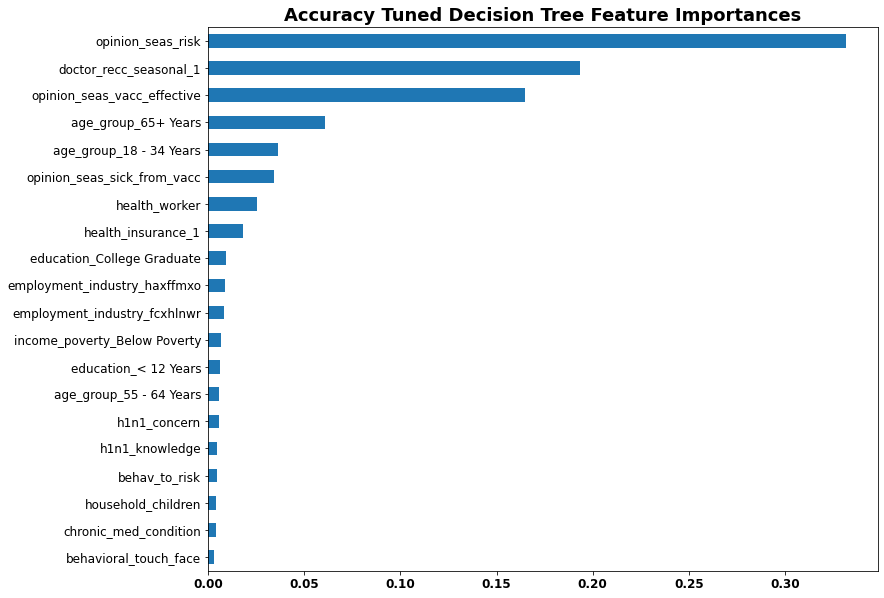

In [402]:
plot_feat_importance(acc_dt_grid.best_estimator_, 'dt', feature_names,
                     model_title='Accuracy Tuned Decision Tree')

> - Both the GridSearch tuned decision trees performed better than the default and were very similar to each other in terms of performance metrics. The decision tree models all performed worse on the test data than the logisitic regression models. This is not necessarily surprising since decision trees have a tendency to overfit on the training data, even after hyperparameter tuning.

## Random Forest

In [404]:
from sklearn.ensemble import RandomForestClassifier

### Baseline Random Forest

> - First fit a baseline random forest model with default parameters and evaluate its performance.

In [405]:
## Use preprocessor as the first step in modeling Pipeline 
rf = Pipeline(steps=[('preprocessing',preprocessing),
                          ('rf', RandomForestClassifier(random_state=random_seed))])

rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'chronic_med_condition',
                                                   'child_under_6_mont

------------------------------------------------------------------
Classification Report: Baseline Random Forest with Default Params
------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.80      0.80      3295
     Vaccine       0.77      0.77      0.77      2940

    accuracy                           0.79      6235
   macro avg       0.78      0.78      0.78      6235
weighted avg       0.79      0.79      0.79      6235

------------------------------------------------------------------
------------------------------------------------------------------




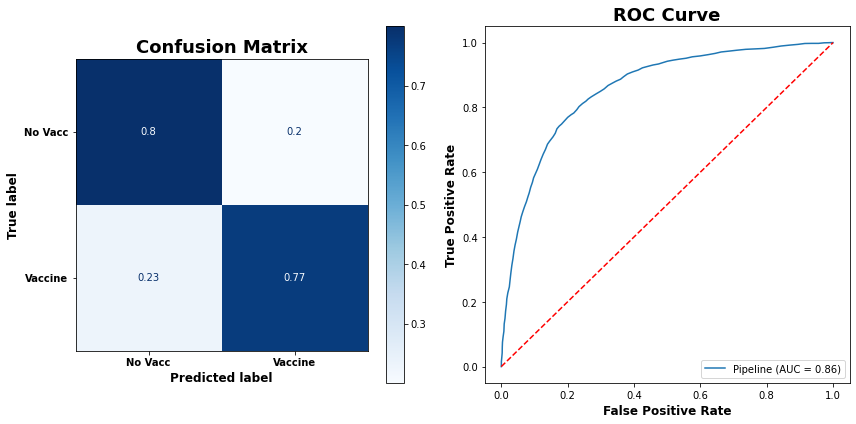

In [406]:
eval_classifier(rf, X_test, y_test, model_descr='Baseline Random Forest with Default Params')

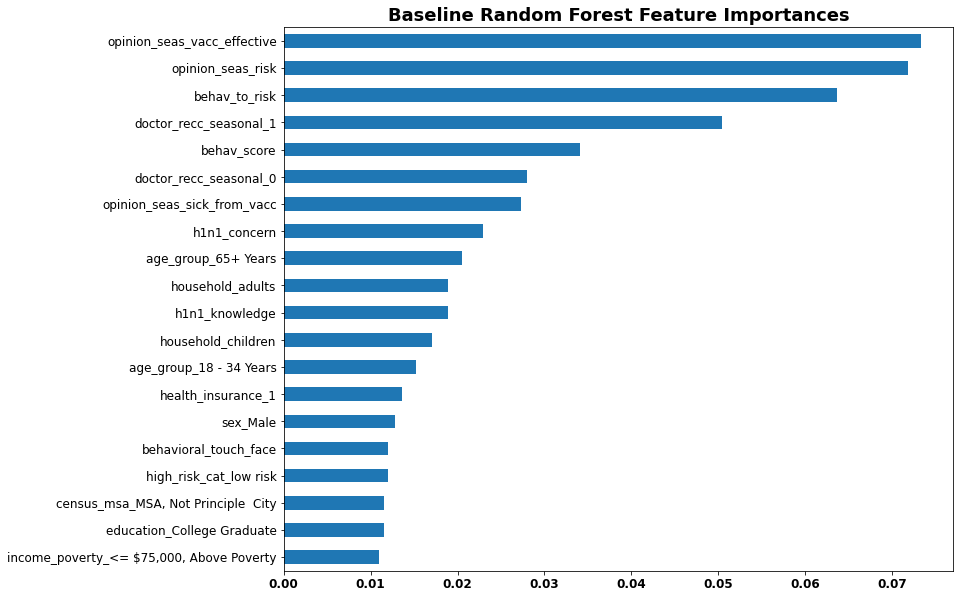

In [407]:
plot_feat_importance(rf, 'rf', feature_names, model_title='Baseline Random Forest')

### GridSearch Random Forest Hyperparameters

#### Select Best Classifier Based on 'recall_macro'

> - Now use GridSearch to tune a random forest classifier to optimize 'recall_macro' (average of the true positive rate for both classes) and evaluate its performance.

In [408]:
## define a grid of different hyperparameter values to be tested
params = {'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 6, 8],
          'rf__class_weight':[None, 'balanced'],
          'rf__min_samples_split':[50, 100],
          'rf__max_features':['sqrt','log2', 50]
         }

## run the grid search to test parameters and find the best estimator 
rec_macro_rf_grid = fit_grid_clf(rf, params, X_train, y_train, score='recall_macro')

## print parameters from best estimator
rec_macro_rf_grid.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__max_features': 50,
 'rf__min_samples_split': 50}

-------------------------------------------------------------------
Classification Report: Recall Macro GridSearch Tuned Random Forest
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.82      0.78      0.80      3295
     Vaccine       0.76      0.80      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------------------
-------------------------------------------------------------------




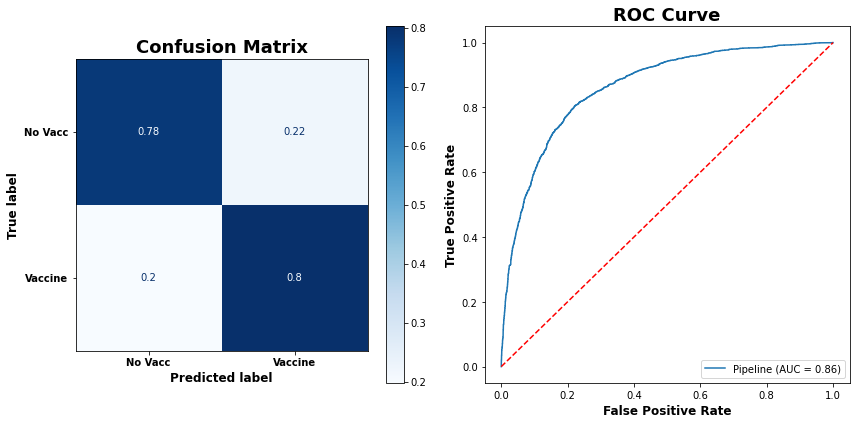

In [409]:
eval_classifier(rec_macro_rf_grid.best_estimator_, X_test, y_test, 
                model_descr='Recall Macro GridSearch Tuned Random Forest')

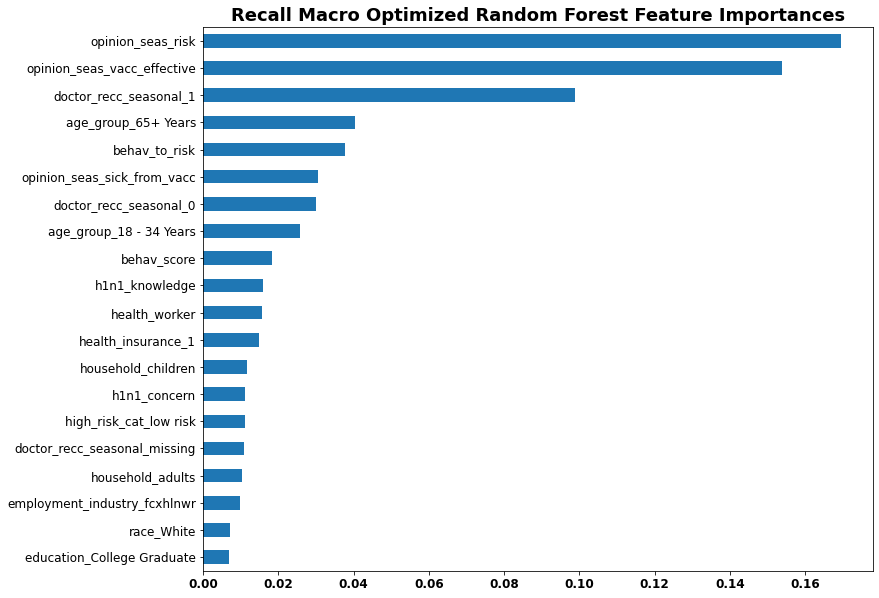

In [410]:
plot_feat_importance(rec_macro_rf_grid.best_estimator_, 'rf', feature_names, 
                     model_title='Recall Macro Optimized Random Forest')

#### Select Best Classifier Based on 'accuracy'

In [411]:
## define a grid of different hyperparameter values to be tested
params = {'rf__criterion':['gini', 'entropy'],
          'rf__max_depth':[None, 6, 8],
          'rf__class_weight':[None, 'balanced'],
          'rf__min_samples_split':[50, 100],
          'rf__max_features':['sqrt','log2', 50]
         }

## run the grid search to test parameters and find the best estimator 
acc_rf_grid = fit_grid_clf(rf, params, X_train, y_train, score='accuracy')

## print parameters from best estimator
acc_rf_grid.best_params_

{'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 50,
 'rf__min_samples_split': 50}

-------------------------------------------------------------------------
Classification Report: Accuracy Optimized GridSearch Tuned Random Forest
-------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.81      0.80      0.80      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------------------------
-------------------------------------------------------------------------




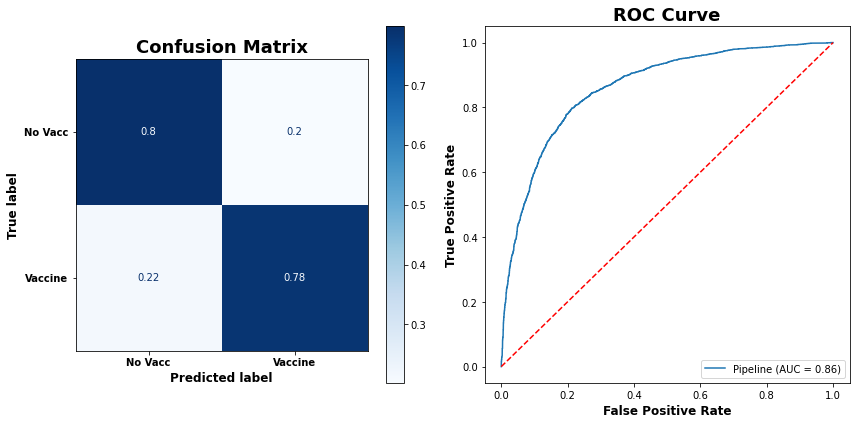

In [412]:
eval_classifier(acc_rf_grid.best_estimator_, X_test, y_test, 
                model_descr='Accuracy Optimized GridSearch Tuned Random Forest')

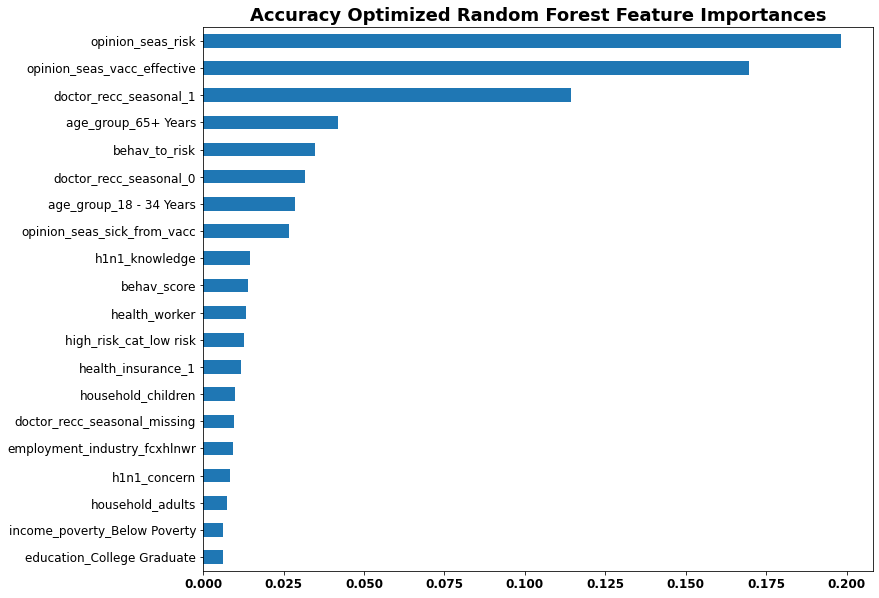

In [413]:
plot_feat_importance(acc_rf_grid.best_estimator_, 'rf', feature_names,
                     model_title='Accuracy Optimized Random Forest')

> - Model performance changed slightly with hyperparameter tuning, but all performed relatively similarly and well. For the purposes of the current problem (maximizing accuracy with a focus on maximizing recall for non-vaccinators) the random forest classifier tuned for accuracy is the best model of the 3. This model had performance metrics nearly identical to the logistic regression models (which all had identical performance), except that recall for people who received the vaccination was 0.01 higher (0.78).

## XGradientBoost

In [415]:
from xgboost import XGBClassifier

### Baseline XGradientBoost

> - First fit a baseline XGradientBoost model with default parameters and evaluate its performance.

In [416]:
## Use preprocessor as the first step in modeling Pipeline 
xgb = Pipeline(steps=[('preprocessing',preprocessing),
                          ('xgb', XGBClassifier(random_state=random_seed))])

xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'chronic_med_condition',
                                                   'child_under_6_mont

-------------------------------------------------------------------
Classification Report: Baseline XGradientBoost with Default Params
-------------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.81      3295
     Vaccine       0.78      0.77      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------------------
-------------------------------------------------------------------




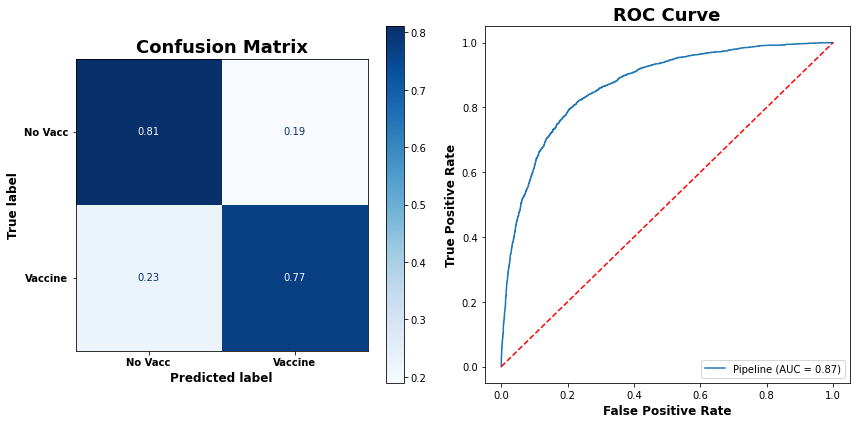

In [417]:
eval_classifier(xgb, X_test, y_test, model_descr='Baseline XGradientBoost with Default Params')

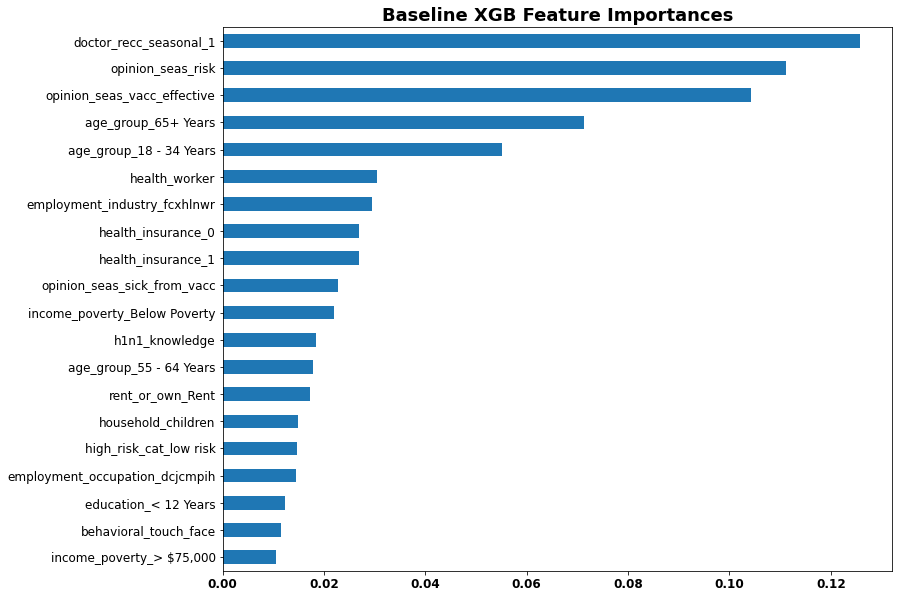

In [418]:
plot_feat_importance(xgb, 'xgb', feature_names, model_title='Baseline XGB')

### GridSearch XGradientBoost Hyperparameters

#### Select Best Classifier Based on 'recall_macro'

> - Now use GridSearch to tune an XGB classifier to optimize 'recall_macro' (average of the true positive rate for both classes) and evaluate its performance.

In [419]:
## define a grid of different hyperparameter values to be tested
params = {'xgb__learning_rate':['0.1', '0.2'],
          'xgb__max_depth':[3, 6, 9],
          'xgb__min_child_weight':[1, 5],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
rec_macro_xgb_grid = fit_grid_clf(xgb, params, X_train, y_train, score='recall_macro')

## print parameters from best estimator
rec_macro_xgb_grid.best_params_

{'xgb__colsample_bytree': 1,
 'xgb__learning_rate': '0.1',
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__subsample': 0.7}

-------------------------------------------------------------
Classification Report: Recall Macro Optimized GridSearch XGB
-------------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.81      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------------
-------------------------------------------------------------




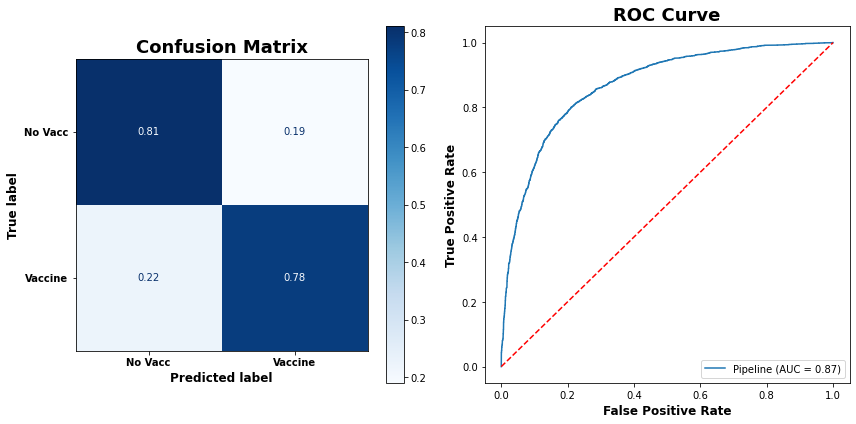

In [420]:
eval_classifier(rec_macro_xgb_grid.best_estimator_, X_test, y_test,
                model_descr='Recall Macro Optimized GridSearch XGB')

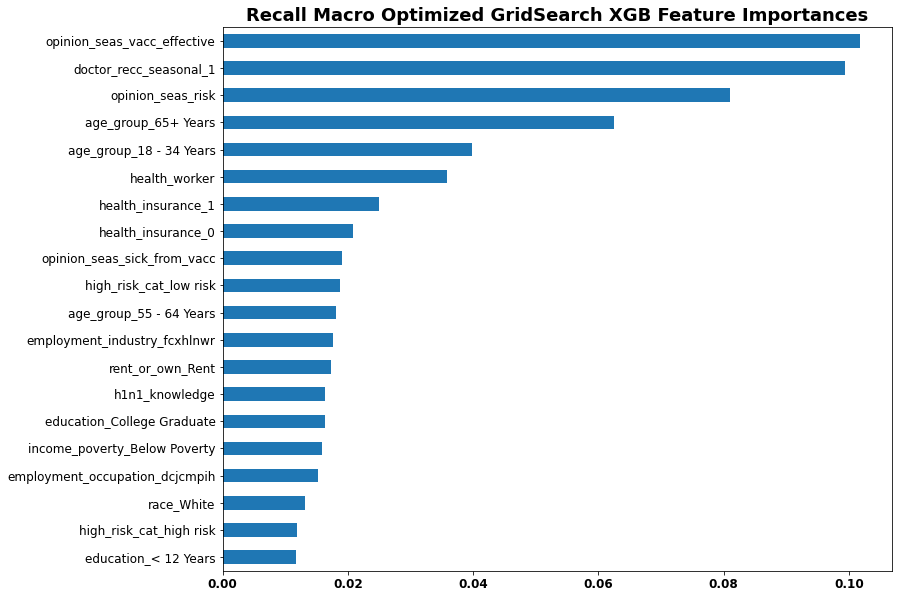

In [421]:
plot_feat_importance(rec_macro_xgb_grid.best_estimator_, 'xgb', feature_names, 
                     model_title='Recall Macro Optimized GridSearch XGB')

#### Select Best Classifier Based on 'accuracy'

In [422]:
## define a grid of different hyperparameter values to be tested
params = {'xgb__learning_rate':['0.1', '0.2'],
          'xgb__max_depth':[3, 6, 9],
          'xgb__min_child_weight':[1, 5],
          'xgb__subsample': [0.7, 1],
          'xgb__colsample_bytree':[0.7, 1]
         }

## run the grid search to test parameters and find the best estimator 
acc_xgb_grid = fit_grid_clf(xgb, params, X_train, y_train, score='accuracy')

## print parameters from best estimator
acc_xgb_grid.best_params_

{'xgb__colsample_bytree': 1,
 'xgb__learning_rate': '0.1',
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__subsample': 0.7}

---------------------------------------------------------
Classification Report: Accuracy Optimized GridSearch XGB
---------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.81      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

---------------------------------------------------------
---------------------------------------------------------




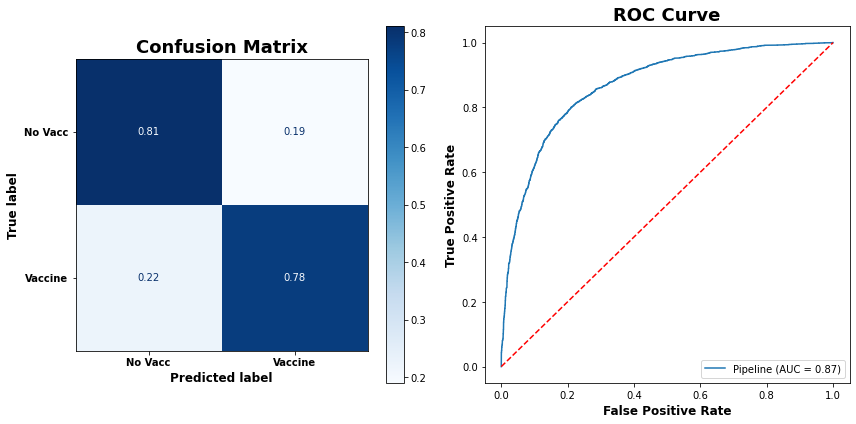

In [423]:
eval_classifier(acc_xgb_grid.best_estimator_, X_test, y_test, 
                model_descr='Accuracy Optimized GridSearch XGB')

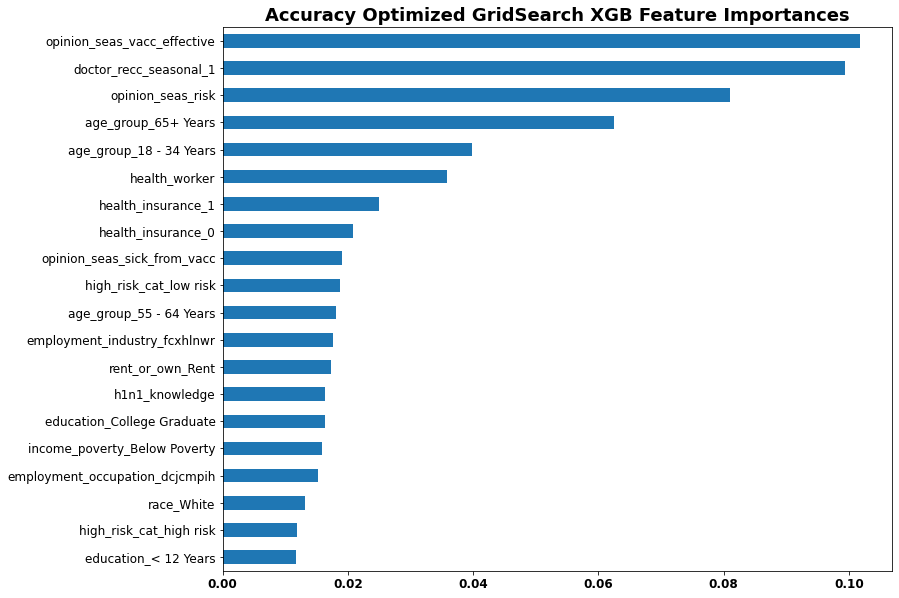

In [424]:
plot_feat_importance(acc_xgb_grid.best_estimator_, 'xgb', feature_names,
                     model_title='Accuracy Optimized GridSearch XGB')

> - Model performance improved very slightly with tuning. The best estimator tuned for 'recall_macro' and the best estimator tuned for 'accuracy' used the same hyperparameters and returned the same top 20 features for predicting. These two models (which are essentially the same model) are the best of any so far, maximizing recall for non-vaccinators, accuracy, and achieving the highest ROC AUC (0.87).

## Stacking Classifier

In [425]:
from sklearn.ensemble import StackingClassifier

> - The best decision tree classifier will not be included in the ensemble because there are already ensembles of decision trees in some of the other best classifiers (random forest, XGB). 
- The following models were found to perform the best out of their category (or were identical to other models in that category):

In [448]:
## best Logistic Regression classifier
best_logreg = acc_logreg_grid.best_estimator_.named_steps['logreg']

## best Random Forest classifier
best_rf = acc_rf_grid.best_estimator_.named_steps['rf']

## best XGB classifier
best_xgb = acc_xgb_grid.best_estimator_.named_steps['xgb']

## estimators to use in stack
best_estimators = [
    ('best_logreg', best_logreg),
    ('best_rf', best_rf),
    ('best_xgb', best_xgb)]

In [450]:
## Use preprocessor as the first step in modeling Pipeline 
stack = Pipeline(steps=[('preprocessing',preprocessing),
                          ('stack', StackingClassifier(estimators=best_estimators, 
                                                       cv=3, n_jobs=-1))])

stack.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'chronic_med_condition',
                                                   'child_under_6_mont

-------------------------------------------------------
Classification Report: Stacking Classifier
-------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.80      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------
-------------------------------------------------------




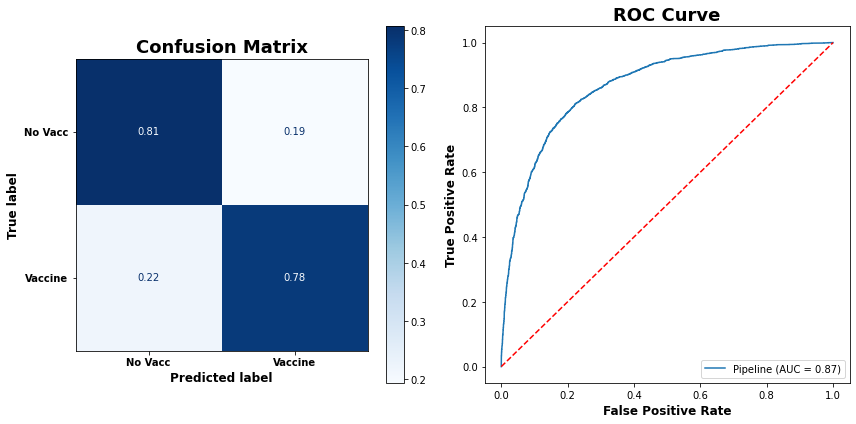

In [451]:
eval_classifier(stack, X_test, y_test, model_descr='Stacking Classifier')

In [452]:
## get estimator names in order to create df to display results
stack_estimators = list(stack.named_steps['stack'].named_estimators.keys())

## get coefficients from the logistic regression that was used to predict 
 ## based on results of stacked classifiers 
  ##(larger coeff = more weight given to that model's predictions)
final_est_coeffs = list(stack.named_steps['stack'].final_estimator_.coef_[0])

## create Pandas DataFrame to display final estimator coefficients
stack_coeffs = pd.DataFrame(data=final_est_coeffs, index=stack_estimators)
stack_coeffs.columns = ['Final Estimator Coefficients']
stack_coeffs

,Final Estimator Coefficients
best_logreg,1.629
best_rf,1.131
best_xgb,2.770


> - The predictions of the stacked classifier were **most influenced by the XGB estimator that was tuned for accuracy**. This is unsurprising since it was one of the best overall models (both tuned XGB classifiers performed well with recall for no vacc = 0.81, recall for vacc = 0.78, accuracy = 0.79, and ROC AUC = 0.87). The best Logistic Regression classifier was the next most influential on the final estimator's predictions, followed by the best Random Forest classifier.

# INTERPRET

> - Overall, the models performed very similarly in terms of all metrics displayed below. As shown, the stacked model performance metrics identical to those of the best XGB classifier with a recall for No Vacc = 0.81, a recall for No Vacc = 0.78, accuracy = 0.79, and ROC AUC of 0.87. Because this ensemble of all the best models relied most heavily on the best XGB classifier, I will focus on interpreting the implications regarding the most important features of that XGB classifier.

*********************************************************************************************************************
********** BEST LOG REG CLASSIFIER -- ACCURACY OPTIMIZED **********

-------------------------------------------------------
Classification Report: Best LogReg (Accuracy)
-------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.79      0.80      0.80      3295
     Vaccine       0.78      0.77      0.77      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------
-------------------------------------------------------




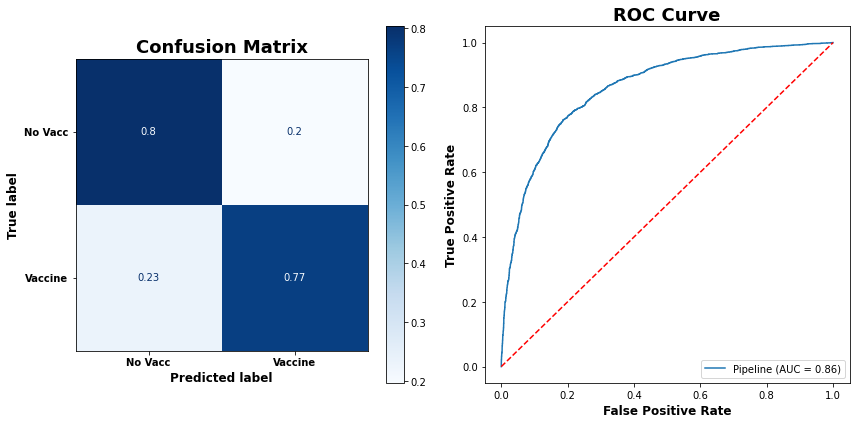

None

*********************************************************************************************************************
********** BEST RANDOM FOREST CLASSIFIER -- ACCURACY OPTIMIZED **********

-------------------------------------------------------
Classification Report: Best Random Forest (Accuracy)
-------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.81      0.80      0.80      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------
-------------------------------------------------------




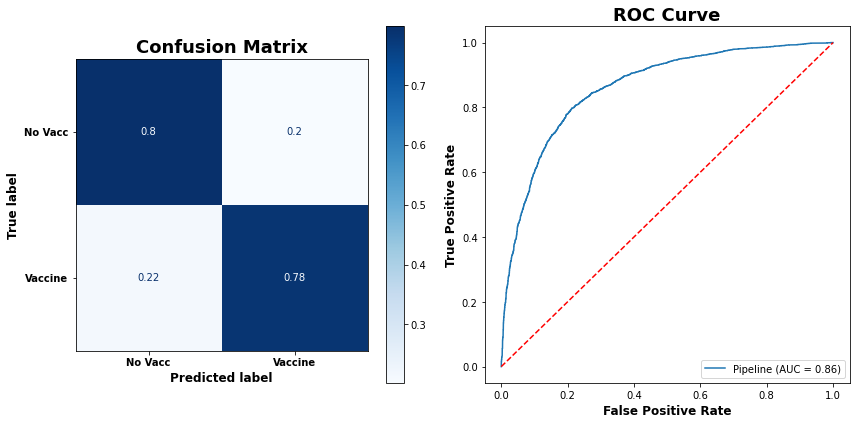

None

*********************************************************************************************************************
********** BEST XGB CLASSIFIER -- ACCURACY OPTIMIZED **********

-------------------------------------------------------
Classification Report: Best XGB (Accuracy)
-------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.81      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------
-------------------------------------------------------




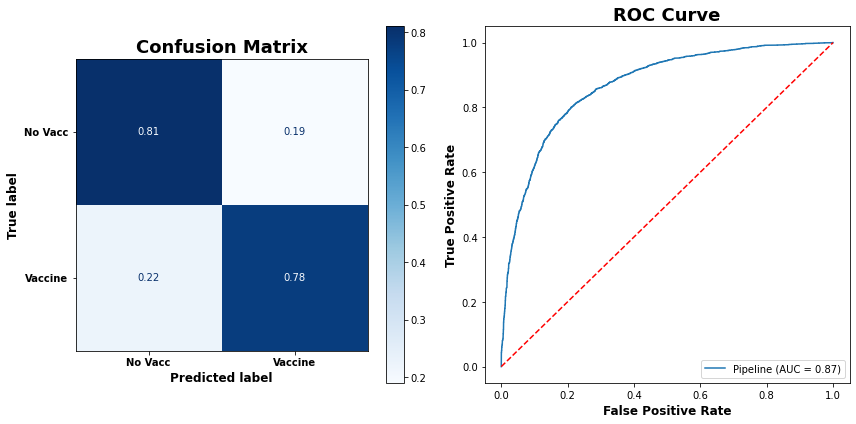

None

*********************************************************************************************************************
********** BEST CLASSIFIER: STACK **********

-------------------------------------------------------
Classification Report: Best Classifier: Stack
-------------------------------------------------------
              precision    recall  f1-score   support

     No Vacc       0.80      0.81      0.80      3295
     Vaccine       0.78      0.78      0.78      2940

    accuracy                           0.79      6235
   macro avg       0.79      0.79      0.79      6235
weighted avg       0.79      0.79      0.79      6235

-------------------------------------------------------
-------------------------------------------------------




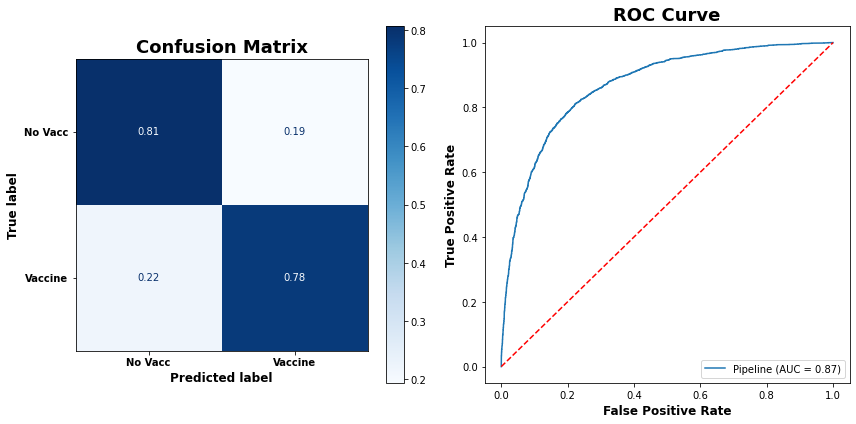

None

In [454]:
print('***'*39)
print('********** BEST LOG REG CLASSIFIER -- ACCURACY OPTIMIZED **********\n')
display(eval_classifier(acc_logreg_grid.best_estimator_, X_test, y_test, model_descr='Best LogReg (Accuracy)'))
print('***'*39)
print('********** BEST RANDOM FOREST CLASSIFIER -- ACCURACY OPTIMIZED **********\n')
display(eval_classifier(acc_rf_grid.best_estimator_, X_test, y_test, model_descr='Best Random Forest (Accuracy)'))
print('***'*39)
print('********** BEST XGB CLASSIFIER -- ACCURACY OPTIMIZED **********\n')
display(eval_classifier(acc_xgb_grid.best_estimator_, X_test, y_test, model_descr='Best XGB (Accuracy)'))
print('***'*39)
print('********** BEST CLASSIFIER: STACK **********\n')
display(eval_classifier(stack, X_test, y_test, model_descr='Best Classifier: Stack'))

> - The most important features used by the top (non-stack) model for predicting whether someone chose to get vaccinated against the seasonal flu are shown below. It should be noted that this graph shows only the weight or importance of each feature, not the direction (positive or negative) of its impact on predicting vaccination status.

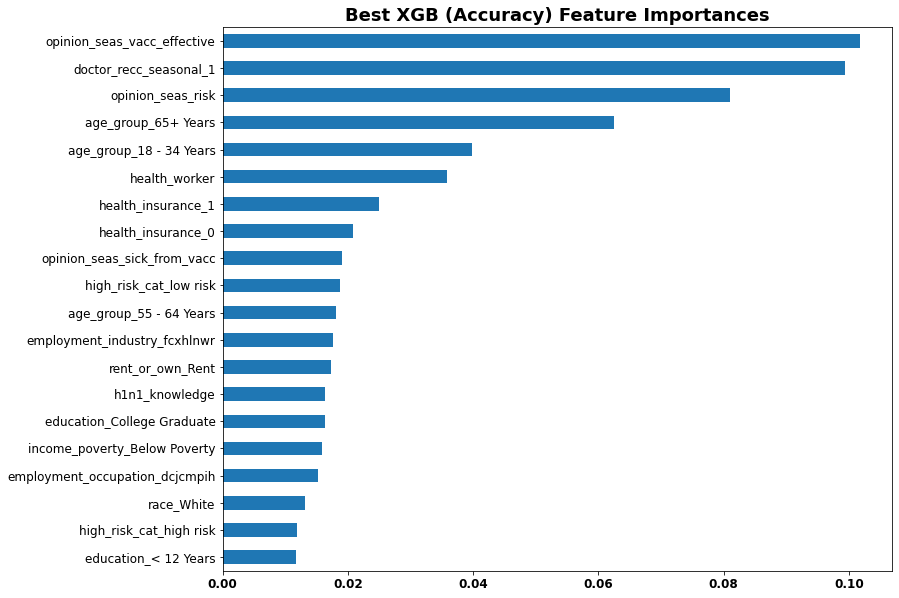

In [432]:
plot_feat_importance(acc_xgb_grid.best_estimator_, 'xgb', feature_names, model_title='Best XGB (Accuracy)')

Features that were the most important for predicting vaccination status were: 
- `opinion_seas_vacc_effective` - how effective on a scale from 1 to 5 (5 being very effective) the respondent believes the vaccine to be at protecting against the flu
- `doctor_rec_seasonal` - whether or not the individual's doctor recommended they get the vaccine, specifically 1: their doctor did recommend getting vaccinated
- `opinion_seasonal_risk` - how concerned on a scale from 1 to 5 (5 being very effective) the respondent is about getting the seasonal flu without the vaccine
- `age_group` - two specific age groups were especially useful for predicting vaccination status: 18-34 years and 65+ years, with a third category (55-64 years) also making it into the top 20 most important features
- `health_worker` - whether or not the individual is a health worker
- `health_insurance` - similarly to the doctor recommendation variable, this shows up twice as an important feature (first as having health insurance, then as not having health insurance, while the third option of declining to answer was less informative for the model)
- `opinion_seas_sick_from_vacc` - perceived risk of getting sick from the vaccine
- `high_risk_cat` - specifically, belonging to the 'low risk' category (having no risk factors that could lead to developing flu-related complications) made it easier for the model to correctly classify an individual, and 'high risk' also showed up in the top 20 features
- `employment_industry` - two industry codes seemed to be useful for making correct predictions: 'fcxhlnwr' and 'dcjcmpih' but it is not known which industries these codes correspond to (however it is likely that at least one is related to being a health worker since that variable was a useful predictor)
- other features that made it into the top 20 most important predictors also included at least one category of the following:
    - `rent_or_own` (homeownership)
    - `h1n1_knowledge`
    - `education`
    - `income_poverty`
    - `race`
    
I will more closely examine trends in how these variables are related to vaccination status in the following sections, in the order of importance shown above.

## Opinion of Flu Vaccine Effectiveness

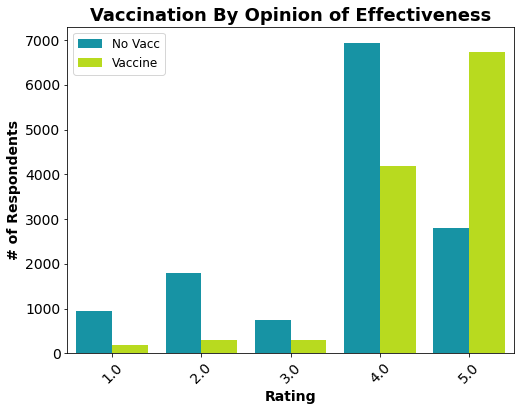

In [434]:
plot_count_by_grp(group='opinion_seas_vacc_effective', data=df,
                  title='Opinion of Effectiveness',
                  x_label='Rating')

> - Unsurprisingly, more people get vaccinated when they believe the vaccine is effective. The majority of people rate the flu vaccine as 4 - Somewhat Effective, but those people are still more likely not to get the vaccine. Only people that rate the vaccine as 5 - Very Effective are more likely to have gotten the vaccine than not. This emphasizes how important it is to provide evidence for and actively communicate to the public about how well the vaccine can protect against the flu virus. 

## Doctor Recommendation

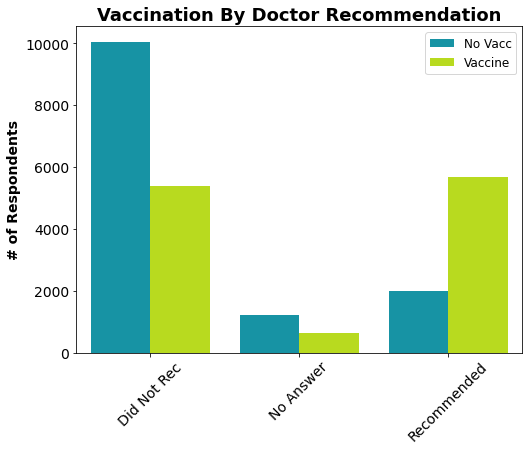

In [433]:
plot_count_by_grp(group='doctor_recc_seasonal', data=df_missing,
                  title='Doctor Recommendation',
                  x_tick_labels=['Did Not Rec', 'No Answer', 'Recommended'])

> - The second most important predictive feature, with nearly as much weight as the first, is having a doctor recommend getting the flu vaccine. People whose physician recommended the vaccine were more likely to have gotten vaccinated.

## Perceived Risk of Contracting Flu without the Vaccine

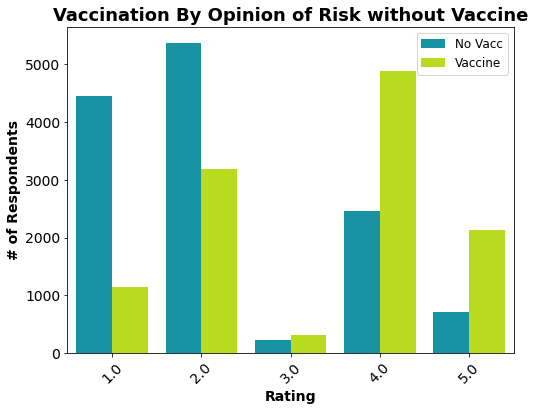

In [435]:
plot_count_by_grp(group='opinion_seas_risk', data=df,
                  title='Opinion of Risk without Vaccine',
                  x_label='Rating')

> - Unsurprisingly when people think they may get sick from getting the vaccine (rating of 1 or 2) they are much less likely to get the vaccine. As people perceive less risk of getting sick from the vaccine, the proportion of individuals getting vaccinated (from rating 4 to rating 5) increases. 

## Age Group

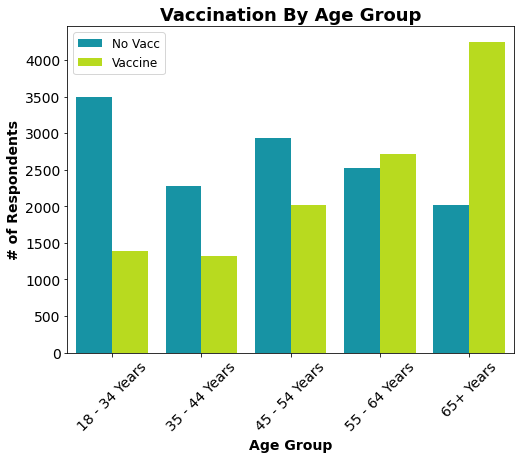

In [436]:
plot_count_by_grp(group='age_group', data=df,
                  title='Age Group',
                  x_label='Age Group',
                  grp_order=['18 - 34 Years', '35 - 44 Years', '45 - 54 Years',
                             '55 - 64 Years', '65+ Years'])

> - Two age groups showed up in the top 5 most important predictive features:
  - **65+ Years**: These individuals were much more likely to have gotten the flu vaccine than not. This is a great sign since individuals in this age category are at greater risk for developing flu-related complications. As such, it's likely that their doctors make sure to recommend the vaccine.
  - **18 - 34 Years**: A much larger proportion of individuals in this age group elect not to get the vaccine than those that do. This age group is not at very high risk of developing complications as a result of the flu, but this would be a key demographic to target and encourage to get vaccinated to maximize the benefits of herd immunity for the population as a whole.
- In general, it appears that the proportion of individuals electing to get vaccinated increases with age.

## Health Worker

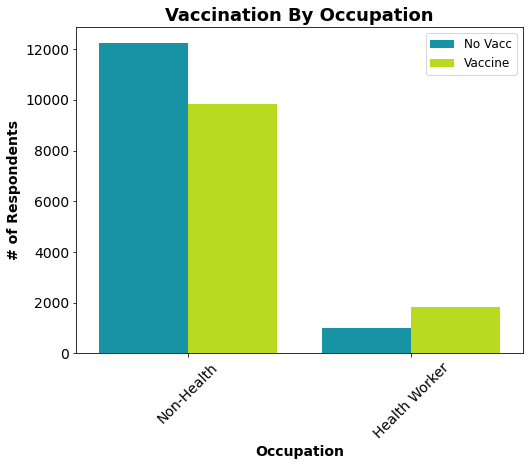

In [438]:
plot_count_by_grp(group='health_worker', data=df,
                  title='Occupation',
                  x_label='Occupation',
                  x_tick_labels=['Non-Health', 'Health Worker'])

> - Health workers are more likely to get the flu vaccine than the rest of the population. This makes sense as it is often required each year for many health professions. Individuals in these professions are also more likely to be well informed about the risks and benefits of vaccination and potential dangers of contracting the seasonal flu.

## Health Insurance

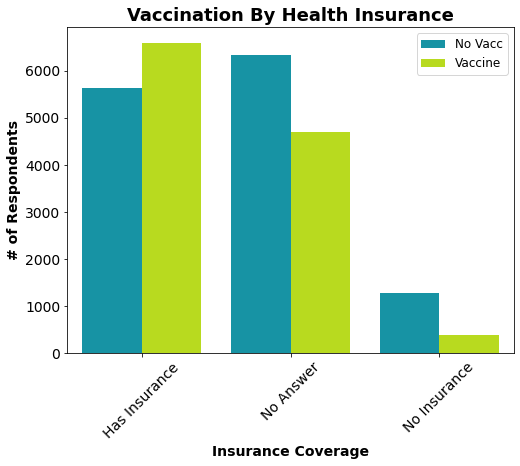

In [439]:
plot_count_by_grp(group='health_insurance', data=df_missing,
                  title='Health Insurance',
                  x_label='Insurance Coverage',
                  x_tick_labels=['Has Insurance', 'No Answer', 'No Insurance'])

> - Both the categories of 'Has Insurance' (1) and 'No Insurance' (0) showed up as important predictive features, in that order. Nearly half the people surveyed declined to answer about their insurance status, but this category was apparently not helpful to the model in distinguising whether an individual got the vaccine or not. People with health insurance are more likely to have gotten the vaccine whereas people without health insurance were very unlikely to have gotten the vaccine. This may be because individuals without health insurance are less likely to see a doctor very often, so they may not have the vaccine recommended to them (a top predictor) and they may also be less informed about the effectiveness and safety of the vaccine or their risk of falling ill and developing complications.

## Perceived Risk of Getting Sick from Flu Vaccine

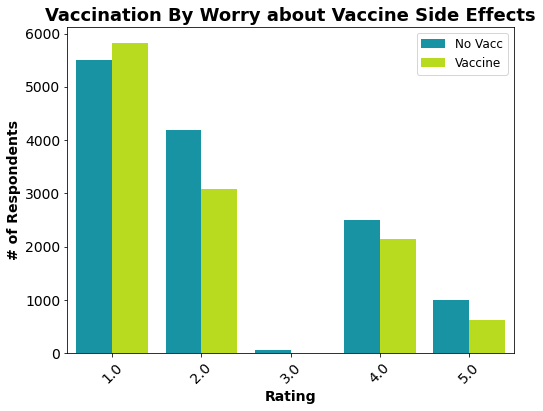

In [456]:
plot_count_by_grp(group='opinion_seas_sick_from_vacc', data=df,
                  title='Worry about Vaccine Side Effects',
                  x_label='Rating')

> - Here a higher rating means the individual is more concerned about getting sick from the flu vaccine itself. Unsurprisingly, people are more likely to get the vaccine if they are less worried about side effects. Health professionals should emphasize and provide evidence for the safety of the flu vaccine.

## Level of Risk for Developing Flu-Related Complications

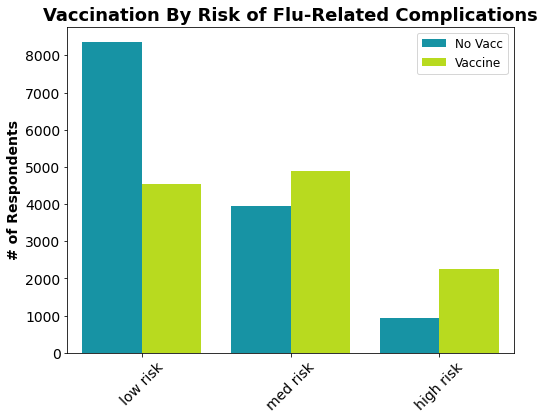

In [437]:
plot_count_by_grp(group='high_risk_cat', data=df,
                  title='Risk of Flu-Related Complications')

> - As the risk of developing complications as a result of the flu increases, so does the proportion of individuals electing to get the vaccine.
- Both the 'low risk' and 'high risk' categories (in that order) made the list of top 20 predictive features. 
- **Low risk** individuals were much less likely to choose to get the seasonal flu vaccine. 
- **High risk** individuals with 2 or more factors that increase risk of developing flu-related complications (such as having a chronic medical condition, being 65 years or older, and/or regularly coming into contact with children 6 months or younger) were much more likely to get vaccinated against the seasonal flu.
- The medium risk category was not very useful as a predictor since individuals in this category were roughly as likely to have gotten the vaccine as not (although a slightly larger portion did elect to get the vaccine).

## Employment Industry

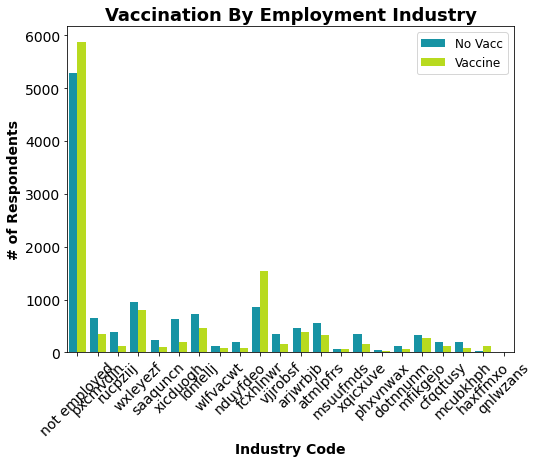

In [440]:
plot_count_by_grp(group='employment_industry', data=df,
                  title='Employment Industry',
                  x_label='Industry Code')

> - Since the industry corresponding to each code is unknown, it is difficult to explain the effects of employment industry on vaccination status. It's possible that at least one of the two categories in the top 20 predictive features ('fcxhlnwr' and 'dcjcmpih') is part of the health industry since being a health worker was a useful predictor of vaccination status.

## Homeownership

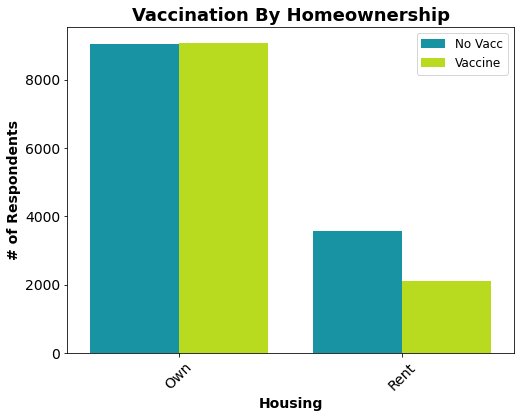

In [445]:
plot_count_by_grp(group='rent_or_own', data=df,
                  title='Homeownership',
                  x_label='Housing')

> - People that own their own homes were about as likely to get the flu vaccine as to not. However, people that rent their housing were less likely to get the vaccine.

## Knowledge about H1N1

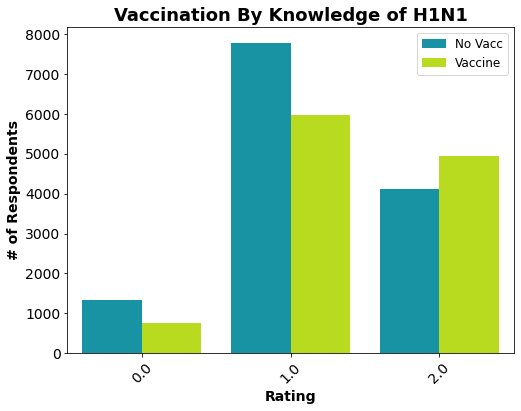

In [443]:
plot_count_by_grp(group='h1n1_knowledge', data=df,
                  title='Knowledge of H1N1',
                  x_label='Rating')

> - A very small proportion of the total sample population (< 10%) acknowledged having no knowledge of H1N1. Of those that had at least some knowledge of H1N1, the proportion of individuals that chose to get vaccinated against the seasonal flu was greater for those more informed about the H1N1 flu.

## Education

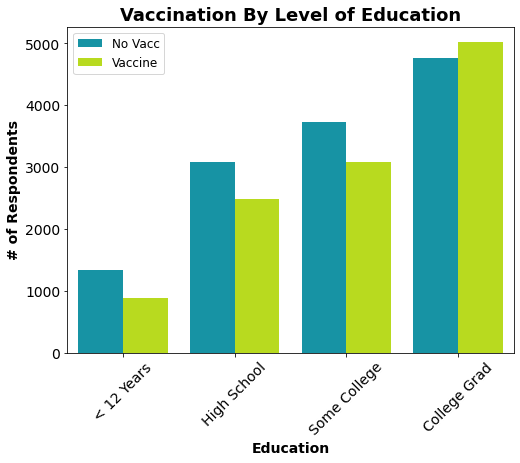

In [446]:
plot_count_by_grp(group='education', data=df,
                  title='Level of Education',
                  x_label='Education',
                  grp_order=['< 12 Years', '12 Years',
                             'Some College', 'College Graduate'],
                  x_tick_labels=['< 12 Years', 'High School',
                                'Some College', 'College Grad'])

> - The proportion of individuals that chose to get vaccinated against the seasonal flu tended to increase with increasing level of education. 
- Of the 4 groups, the college graduate category was the most useful for predicting whether or not someone had elected to get vaccinated. This was the only group where the proportion of individuals that got the vaccine was greater than the proportion that did not.
- The category '< 12 Years' of education also made it into the list of the top 20 predictive features. Individuals in this category are less likely to choose to get the vaccine.

## Income

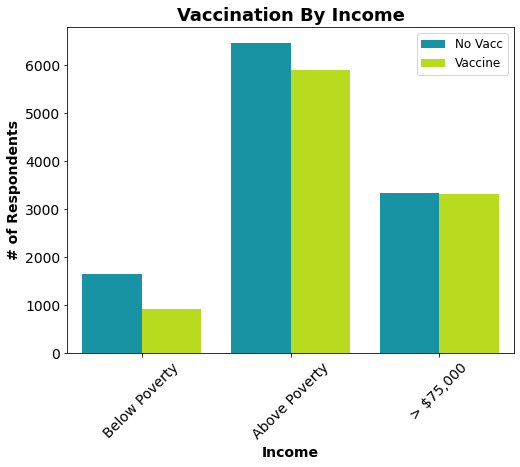

In [441]:
plot_count_by_grp(group='income_poverty', data=df,
                  title='Income',
                  x_label='Income',
                  x_tick_labels=['Below Poverty', 'Above Poverty', '> $75,000'])

> - Of the 3 income categories, only 'Below Poverty' stood out as a useful predictor. Individuals living with a household income below the 2008 Census poverty threshold are less likely to get the vaccine. The proportion of non-vaccinated versus vaccinated individuals is much more balanced in the other 2 income categories.

## Race

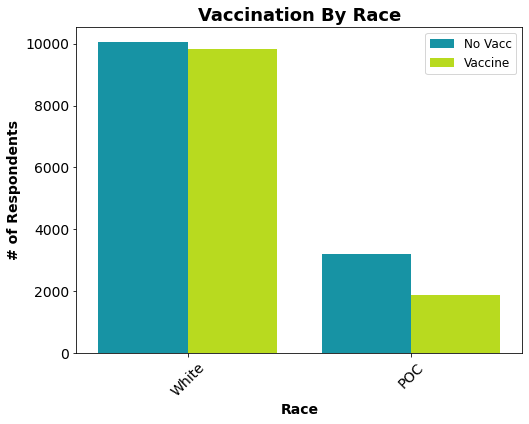

In [444]:
plot_count_by_grp(group='race', data=df,
                  title='Race',
                  x_label='Race')

> - It should be noted that the dataset used for this project is extremely imbalanced in terms of race, with 79.6% of the respondents being white, and the remaining 20.4% made up of the original groups: Black, Hispanic, and Other or Multiple. These 3 original classifications were regrouped into one category representing all people of color.
- 'White' emerged as one of the top 20 predictive features. White respondents were about as likely to have gotten the vaccine as not, but people of color were less likely to get vaccinated. This has important implications, especially in light of the disproportionately heavy impact of the current COVID-19 pandemic on communities of color. The impending flu season may interact to produce even more drastic impacts on these communities.

# Conclusions/Recommendations

In [447]:
final_data = df.copy()
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24939 entries, 0 to 26706
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 24939 non-null  float64
 1   h1n1_knowledge               24939 non-null  float64
 2   behavioral_avoidance         24939 non-null  float64
 3   behavioral_face_mask         24939 non-null  float64
 4   behavioral_wash_hands        24939 non-null  float64
 5   behavioral_large_gatherings  24939 non-null  float64
 6   behavioral_outside_home      24939 non-null  float64
 7   behavioral_touch_face        24939 non-null  float64
 8   doctor_recc_seasonal         23088 non-null  object 
 9   chronic_med_condition        24939 non-null  float64
 10  child_under_6_months         24939 non-null  float64
 11  health_worker                24939 non-null  float64
 12  health_insurance             13896 non-null  object 
 13  opinion_seas_vac

In [121]:
# folder = %pwd

# data_filepath = folder+'/Data_files/'

# #save final DataFrame
# final_data.to_csv(data_filepath+'final_data.csv')